<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 1
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Introducción

En el siguiente trabajo práctico se propone abordar un problema real de ciencia de datos, investigar cada una de las etapas del proceso y resolverlo aplicando los contenidos desarrollados en clase.  
También, a partir de un conjunto de datos de reservas de hotel proveídos por la cátedra, aplicar técnicas de análisis exploratorio, preprocesamiento de datos y entrenar un modelo de clasificación con el objetivo de predecir si una reserva será o no cancelada.

# Análisis Exploratorio y Preprocesamiento de Datos

## Exploración Inicial

### Carga inicial de dependencias y datos

En primer lugar, se cargan las dependencias a utilizar

In [215]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

y se cargan los datos de reserva de hoteles en el siguiente dataframe:

In [216]:
hotels_train_url = 'hotels_train.csv'
hotels_df = pd.read_csv(hotels_train_url)
hotels_df_backup = hotels_df.copy()

Se modifica el tamaño por defecto de los gráficos:

In [217]:
plt.rcParams['figure.figsize'] = [4, 4]

A continuación, se presentan las primeras 5 filas listadas con todas las respectivas columnas para tener una idea general de como se ven los datos para comenzar a analizarlos:

In [218]:
hotels_df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,Non Refund,154.0,NaN,0,Transient,75.0,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,No Deposit,20.0,NaN,0,Transient-Party,75.0,0,1,28c75445-c603-413a-babf-ad377018b592,0


Hay un total de 31 columnas. De todos estos parámetros, se tendrán en cuenta aquellos que sirvan, en nuestro criterio, sean de utilidad para entrenar el modelo predictivo.  
Se propone analizar cada parámetro individualmente y, al finalizar, presentar un pequeño resumen con las conclusiones de este análisis inicial.

Antes de realizar el análisis de cada parámetro, se ve que las fechas de las reservas están expresadas separando el día, mes y año. Como probablemente se necesite graficar fechas, se crea una nueva columna que indique la indique directamente:

In [219]:
aux = []

for i in range(hotels_df.hotel.count()):
    # Para cada fila meto todos los datos de fechas en un solo atributo
    for j in range(13):
        # Si el nombre del mes coincide con el guardado, termino de crear el nuevo atributo
        if hotels_df.arrival_date_month[i]==calendar.month_name[j]:
            aux.append(datetime.date.fromisoformat (str(hotels_df.arrival_date_year[i]).zfill(4)\
            + "-" + str(j).zfill(2)\
            + "-" + str(hotels_df.arrival_date_day_of_month[i]).zfill(2))) 
            break    

hotels_df['arrival_date'] = aux

### Parámetros

#### hotel

El parámetro es un _string_ que indica el nombre del Hotel. En un principio, podría pensarse que resulta irrelevante para el entrenamiento del modelo propuesto en sí y respecto a su relación con el target, pero lo mejor es investigar un poco más. Podría llegar a suceder que un hotel tenga más cancelaciones que otro/s, y esto es un motivo a tener en cuenta. Sin embargo, si tuviese las reservas de un solo hotel, no sería necesario tenerlo en cuenta, puesto que solo trataría parámetros de ese hotel y sería un modelo predictivo para dicho hotel unicamente.

Se propone verificar la cantidad de valores únicos que aparecen en dicha columna:

In [220]:
hotel_unique = hotels_df['hotel'].unique()
hotel_unique_cant = len(hotel_unique)

print("La cantidad de hoteles cargados en el .CSV es de: ", hotel_unique_cant)
print()
print("Estos hoteles son: ", hotel_unique)

La cantidad de hoteles cargados en el .CSV es de:  2

Estos hoteles son:  ['City Hotel' 'Resort Hotel']


Entonces, se sabe que los datos obtenidos pertenecen a dos hoteles de nombres: "City Hotel" y "Resort Hotel".

Por otro lado, el parámetro es una **Variable Independiente Cualitativa de tipo Texto y es Nominal** ya que es una etiqueta (nombre del hotel) con valores no relacionados entre sí. Es, simplemente, una forma de identificar el establecimiento.  
Se propone obtener la cantidad de veces que aparecen ambos hoteles en las celdas y su frecuencia:

In [221]:
hotel_counts = hotels_df['hotel'].value_counts()
hotel_percentage = hotels_df['hotel'].value_counts(normalize=True)

print("La cantidad de veces que aparecen los hoteles son: ")
print(hotel_counts)
print()
print("Los porcentajes de aparición del nombre de los hoteles con respecto al total son: ")
print(hotel_percentage)

La cantidad de veces que aparecen los hoteles son: 
hotel
City Hotel      42129
Resort Hotel    19784
Name: count, dtype: int64

Los porcentajes de aparición del nombre de los hoteles con respecto al total son: 
hotel
City Hotel      0.680455
Resort Hotel    0.319545
Name: proportion, dtype: float64


Se puede observar que la mayoría de los registros provienen del _City Hotel_, siendo un poco menos del 70% del total.

Se presentan, a modo de visualización, dos **gráficos** con la cantidad de veces que aparece cada nombre:

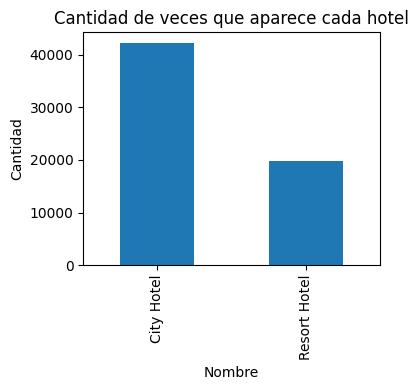

In [222]:
plt.figure()
hotel_counts.plot(kind='bar')
plt.xlabel('Nombre')
plt.ylabel('Cantidad')
plt.title('Cantidad de veces que aparece cada hotel')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

En forma de gráfico de torta:

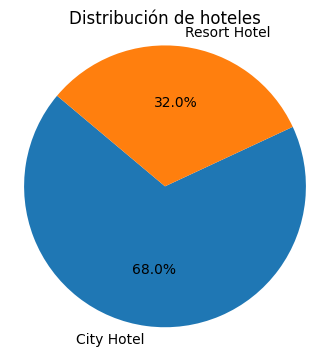

In [223]:
plt.figure()
plt.pie(hotel_counts, labels=hotel_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribución de hoteles')
plt.show()

Finalmente, se propone analizar la cantidad de cancelaciones según hotel:

In [224]:
city_hotel_df = hotels_df[hotels_df['hotel'] == "City Hotel"]
city_hotel_cancelations = city_hotel_df[city_hotel_df['is_canceled'] == 1]
city_hotel_cancelations_percentage = len(city_hotel_cancelations) / len(city_hotel_df)

resort_hotel_df = hotels_df[hotels_df['hotel'] == "Resort Hotel"]
resort_hotel_cancelations = resort_hotel_df[resort_hotel_df['is_canceled'] == 1]
resort_hotel_cancelations_percentage = len(resort_hotel_cancelations) / len(resort_hotel_df)

print("La cantidad de cancelaciones para el City Hotel es de: ", city_hotel_cancelations_percentage)
print()
print("La cantidad de cancelaciones para el Resort Hotel es de: ", resort_hotel_cancelations_percentage)

La cantidad de cancelaciones para el City Hotel es de:  0.5486007263405255

La cantidad de cancelaciones para el Resort Hotel es de:  0.3957238172260412


Se propone mostrar los resultados en dos gráficos de torta, uno por cada hotel:

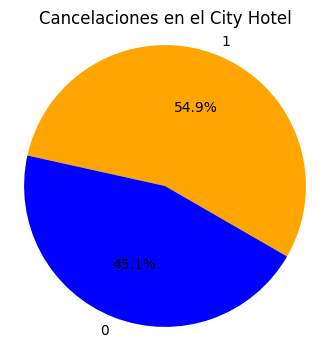

In [225]:
city_hotel_target_counts = city_hotel_df['is_canceled'].value_counts()

colores = ['orange', 'blue']

plt.figure()
plt.pie(city_hotel_target_counts, labels=city_hotel_target_counts.index, autopct='%1.1f%%', startangle=-30, colors=colores)
plt.axis('equal')
plt.title('Cancelaciones en el City Hotel')
plt.show()

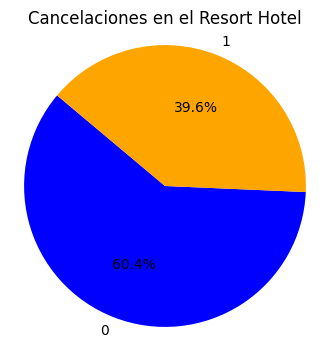

In [226]:
resort_hotel_target_counts = resort_hotel_df['is_canceled'].value_counts()

colores = ['blue', 'orange']

plt.figure()
plt.pie(resort_hotel_target_counts, labels=resort_hotel_target_counts.index, autopct='%1.1f%%', startangle=140, colors=colores)
plt.axis('equal')
plt.title('Cancelaciones en el Resort Hotel')
plt.show()

De esta manera, se puede observar que es más probable, un 15% más probable, que una reserva sea cancelada si proviene del _City Hotel_ que si lo hace del _Resort Hotel_. Por lo tanto, el parámetro _hotel_ es **relevante** y está relacionado con el **target**.  
No se pueden explicar las razones en principio, pero si se puede afirmar que es un parámetro relevante para el entrenamiento del modelo predictivo.

#### lead_time

El parámetro indica el número de días que transcurrieron entre la fecha de entrada de la reserva en el PMS y la fecha de ingreso del cliente al hotel. En principio, podría pensarse que aporta información relevante con respecto al target, pero es necesario investigar más.

El parámetro es un _integer_ de tipo **Variable Independiente Cuantitativa Discreta**, ya que es una medida discreta del tiempo y no se toman otros intervalos de tiempo. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al target y la Correlación de Pearson con respecto al target.

In [227]:
parameter_column = hotels_df['lead_time'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  112.24818697204141
Mediana:  78.0
Varianza:  12258.267122558873
Desviación Estandar:  110.71705885977497
Moda:  0
Covarianza (con respecto a target):  16.265487254459007
Correlación de Pearson (con respecto a target):  0.2938160884261427


La **Media** indica el valor promedio obtenido, que teniendo en cuenta lo desarrollado anteriormente, puede aproximarse a 112 días.

La **Mediana** indica el valor que se encuentra en el centro de un conjunto de datos al estar ordenados en orden ascendente o descendente. En este caso, el valor obtenido es de 78 días, pero para decidir cual utilizar en caso de una corrección (si la Media o la Mediana), lo mejor es visualizar los datos en un gráfico y observar su distribución.

La **Varianza** indica cuán dispersos o agrupados están los valores en relación con la media (promedio) de los datos.

La **Desviación Estandar** se utiliza para cuantificar la dispersión o la variabilidad de un conjunto de datos. En este caso, el valor es muy grande, más de lo esperable, lo que llevaría a pensar que es posible que haya valores atípicos o que necesiten corrección.

La **Moda** representa el valor, o los valores, más frecuentes en el conjunto de datos. En este caso, el 0 podría indicar que la reserva se hizo el mismo día de llegada (osea no hubo reserva), o bien que no se tienen datos concretos para esa fila. Se debe realizar una investigación más profunda.

La **Covarianza** es positiva, significa que cuando una variable aumenta, la otra tiende a aumentar también. Si fuera negativa, sería el caso contrario y su fuese cero (o cercana a cero) no tendrian relación entre sí. Dado que la covarianza puede ser afectada por valores atípicos en los datos, esto puede hacer que sea difícil de interpretar. Por lo que se propone, analizar también la Correlación de Pearson.  

En el caso de la **Correlación de Pearson**, dado que es positiva, esto podría indicar que a medida que el tiempo entre la reserva y la fecha de llegada aumenta, la probabilidad de cancelación tiende a aumentar, lo que podría sugerir una relación positiva. Si fuese negativa esto indicaría una relación inversa y si fuese 0 no se observaría una relación lineal fuerte entre estas dos variables.
Dado que su relación, es más cercana a 0 que 1, pero positiva, se puede concluir que su relación no es completamente fuerte, pero se espera una mayor cancelación de la reserva a medida que pasa el tiempo.

Se propone continuar investigando mediante un gráfico de barras en el tiempo:

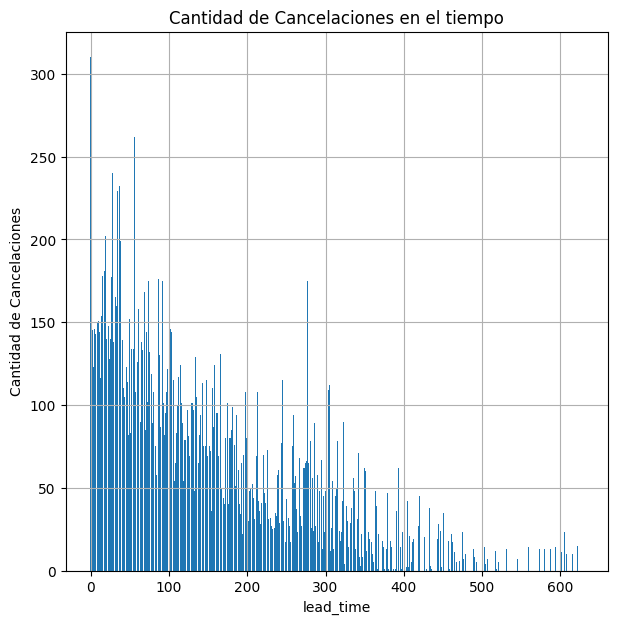

In [228]:
hotels_cancelations = hotels_df[hotels_df['is_canceled'] == 1]
hotels_cancelations_per_lead_time = hotels_cancelations['lead_time'].value_counts().sort_index()

plt.figure(figsize=(7, 7))
plt.bar(hotels_cancelations_per_lead_time.index, hotels_cancelations_per_lead_time.values)
plt.xlabel('lead_time')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones en el tiempo')
plt.grid(True)
plt.show()

Del gráfico superior se deduce que la mayor cancelación de reservas ocurre en los primeros 100 días y luego comienza a descender, aunque tiene sentido también porque menos gente reserva con tanto tiempo de antelación. Para verificar el porcentaje de cancelaciones con respecto al tiempo, se propone dividir el *lead_time* en intervalos de 30 días (aproximadamente 1 mes).

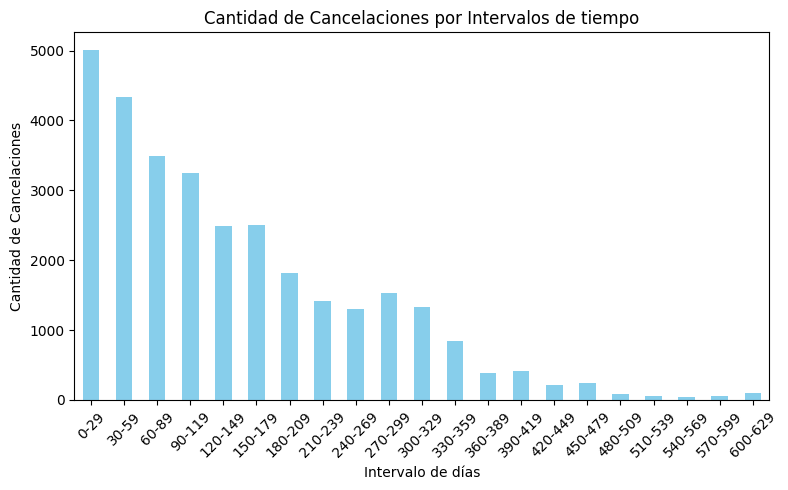

In [229]:
hotels_lead_time_cancel_intervals = list(range(0, max(hotels_cancelations["lead_time"].tolist()) + 31, 30))
hotels_lead_time_cancel_labels = [f'{i}-{i+29}' for i in hotels_lead_time_cancel_intervals[:-1]]
hotels_cancelations_per_lead_time_intervalos = pd.cut(hotels_cancelations_per_lead_time.index, bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
hotel_cancelations_per_interval = hotels_cancelations_per_lead_time.groupby(hotels_cancelations_per_lead_time_intervalos, observed=False).sum()

plt.figure(figsize=(8, 5))
hotel_cancelations_per_interval.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Cancelaciones por Intervalos de tiempo')
plt.xlabel('Intervalo de días')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

Este gráfico es más claro que el anterior incluso, ya que toma períodos de tiempo. Para poder comparar si realmente es relevante la variable, se propone ahora tomar porcentajes por intervalos.

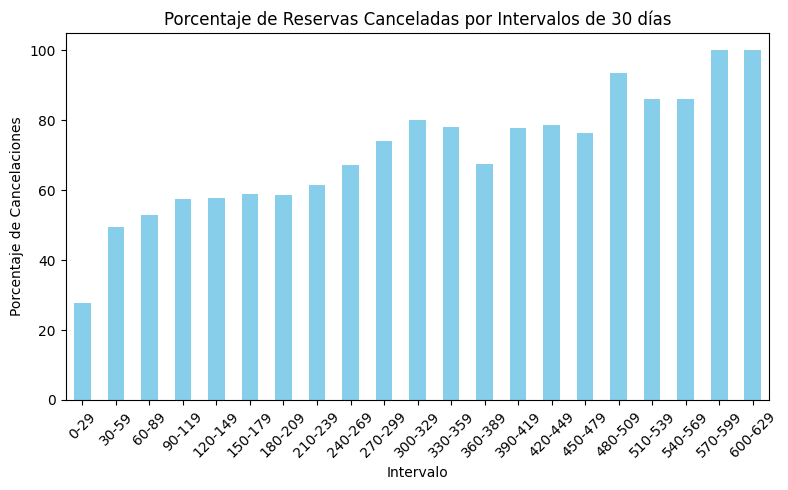

In [230]:
hotels_df['lead_time_intervals'] = pd.cut(hotels_df['lead_time'], bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['lead_time_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['lead_time_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 5))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Intervalos de 30 días')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

Como puede observarse, con una reserva de menos de 30 días las probabilidades de que dicha reserva sea cancelada son mucho menores a las de mayor tiempo. A partir de los 2 meses las probabilidades superan el 50% y a medida que pasa el tiempo es aún más probable. Incluso a partir de los 570 días ya es una 100% de probabilidad de que dicha reserva sea cancelada.

Esto significa que *lead_time* es un parámetro **relevante** para el entrenamiento del modelo y, además, que está relacionado con **target**.  
Por otro lado, también es un indicador de que cuanto más tiempo pase, más probable será que la reserva sea cancelada.

#### arrival_date_year

El parámetro describe el año de arribo. En sí, no es un parámetro relevante para predecir futuras cancelaciones de reservas. Es un dato que puede resultar útil para estudiar porque hubo un aumento o disminución de reservas, por ejemplo por alguna crisis mundial económica; pero más allá de eso, no servirá para entrenar el modelo. Aunque podría utilizarse, para predecir las cancelaciones en esos años en concreto, pero la idea sería poder utilizar el modelo en el futuro en los próximos años, por lo que es **irrelevante** y su relación con el **target** ayuda a explicar hechos pasados, pero no necesariamente futuros en este caso puntual.

Por otro lado, es una **Variable Independiente Cuantitativa Discreta**, ya que es un intervalo de tiempo discretizado. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al target y la Correlación de Pearson con respecto al target.

In [231]:
parameter_column = hotels_df['arrival_date_year'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2016.1547494064253
Mediana:  2016.0
Varianza:  0.5018065016562059
Desviación Estandar:  0.7083830190343399
Moda:  2016
Covarianza (con respecto a target):  0.007056767925435907
Correlación de Pearson (con respecto a target):  0.019923274956089875


La mayoría de las reservas ocurrieron en el 2016, los años poseen una desviación estandar chica. Además, la covarianza y la correlación de Pearson revelan un valor muy cercano a 0, por lo que no guardan una relación fuerte con el **target**.

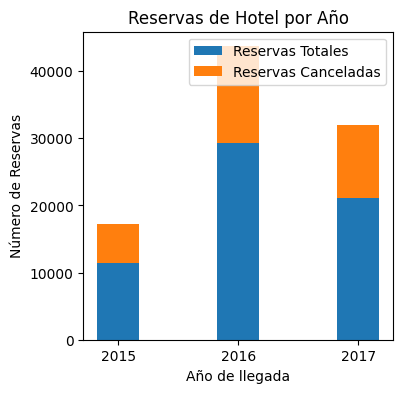

In [232]:
total_reservas_per_year = hotels_df.groupby('arrival_date_year')['is_canceled'].count()
reservas_canceladas_per_year = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_year')['is_canceled'].count()
years = total_reservas_per_year.index
fig, ax = plt.subplots()
ancho_barra = 0.35
barra_total = ax.bar(years, total_reservas_per_year,\
                        width = ancho_barra,\
                        label='Reservas Totales')
barra_cancelada = ax.bar(years, reservas_canceladas_per_year,\
                         width = ancho_barra,\
                         label = 'Reservas Canceladas',\
                         bottom = total_reservas_per_year)


ax.set_xlabel('Año de llegada')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas de Hotel por Año')
ax.set_xticks(years)
ax.legend()
plt.show()

Si bien se puede observar que la mayor cantidad de reservas provienen del año 2016, el porcentaje de reservas/cancelaciones parecería ser el mismo. A continuación, se puede verificar esto:

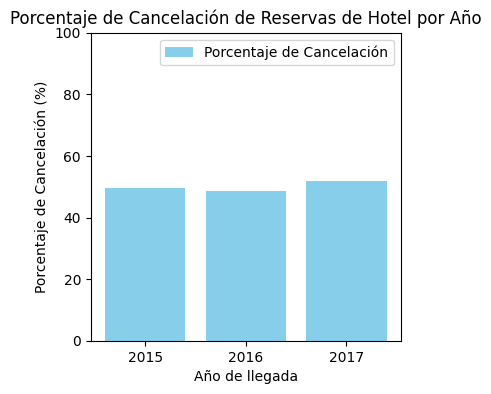

In [233]:
cancelations_perc_per_year = (hotels_df.groupby('arrival_date_year')['is_canceled'].mean() * 100).round(2)

years = cancelations_perc_per_year.index
fig, ax = plt.subplots()
ax.bar(years, cancelations_perc_per_year, color='skyblue', label='Porcentaje de Cancelación')
ax.set_ylim(0, 100)

ax.set_xlabel('Año de llegada')
ax.set_ylabel('Porcentaje de Cancelación (%)')
ax.set_title('Porcentaje de Cancelación de Reservas de Hotel por Año')
ax.set_xticks(years)
ax.legend()

plt.show()

Como puede observarse, el porcentaje de cancelación de reservas se mantiene aproximadamente constante.

#### arrival_date_month

De forma similar al anterior, este parámetro podría decirse que continúa con la misma línea de pensamiento, pero es necesario investigar para estar seguros, ya que podría suceder que haya más cancelaciones según la época del año.

Es una **Variable Independiente Cualitativa Texto Nominal** debido a que es una etiqueta no relacionada, que solamente indica el mes.

A continuación, se presentan el mes con mayor cantidad de reservas y el que posee mayor cantidad de cancelaciones:

In [234]:
arrival_date_month_more_reservations =  hotels_df['arrival_date_month'].mode().iloc[0]
arrival_date_month_more_cancelations =  hotels_df[hotels_df["is_canceled"] == 1]['arrival_date_month'].mode().iloc[0]

print("Mes con mayor cantidad de reservas: ", arrival_date_month_more_reservations)
print("Mes con mayor cantidad de cancelaciones: ", arrival_date_month_more_cancelations)


Mes con mayor cantidad de reservas:  August
Mes con mayor cantidad de cancelaciones:  August


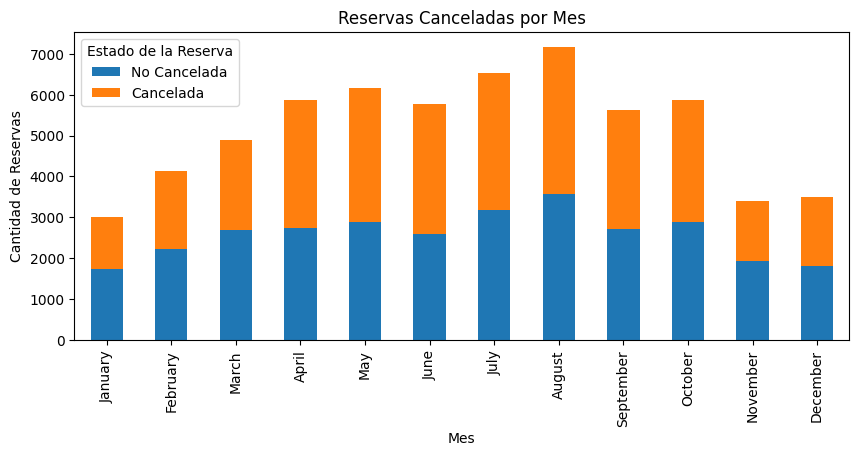

In [235]:
monthly_cancelations = hotels_df.groupby(['arrival_date_month', 'is_canceled']).size().unstack()
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelations = monthly_cancelations.reindex(ordered_months)

ax = monthly_cancelations.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Reservas')
plt.legend(['No Cancelada', 'Cancelada'], title='Estado de la Reserva')

plt.show()

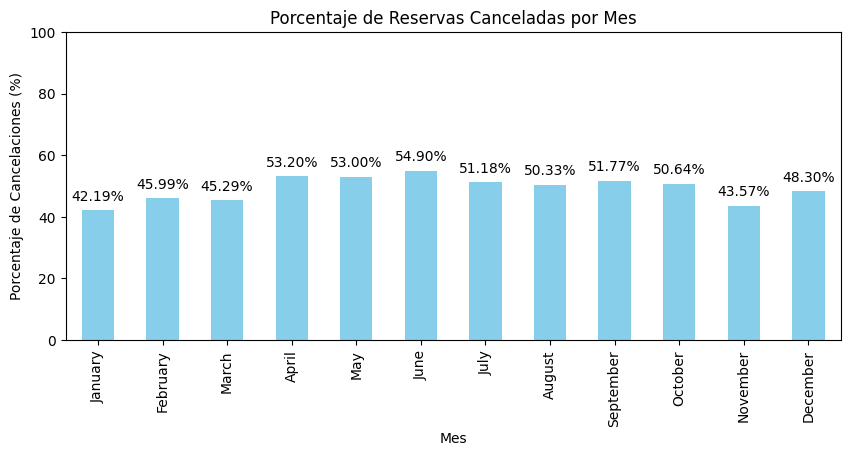

In [236]:
monthly_totals = hotels_df.groupby('arrival_date_month').size()
monthly_cancelations = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_month').size()
monthly_cancelation_percentage = (monthly_cancelations / monthly_totals) * 100
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelation_percentage = monthly_cancelation_percentage.reindex(ordered_months)

max_percentage = monthly_cancelation_percentage.max()

ax = monthly_cancelation_percentage.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Cancelaciones (%)')
plt.ylim(0, 100)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

Como puede observarse en el gráfico superior, hay mayor cantidad de cancelaciones en Junio que en Enero, por lo que es un parámetro **relevante** a la hora de entrenar el modelo y se debe destacar que mantiene una relación con respecto al **target**.

#### arrival_date_week_number

Este parámetro se refiere al número de semana en el año en que está la reserva. Puede llegar a ser importante para determinar temporadas altas o bajas, aunque la información que da debería ser la misma que la de arrival_date_month solo que con algo más de información. Es una **Variable Independiente Cuantitativa Discreta**, puesto que es una discretización del tiempo. 

Entonces, se propone mostrar las medidas de resumen:

In [237]:
parameter_column = hotels_df['arrival_date_week_number'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  27.21808020932599
Mediana:  28.0
Varianza:  182.95000211609326
Desviación Estandar:  13.525901157264652
Moda:  33
Covarianza (con respecto a target):  0.05652184137557416
Correlación de Pearson (con respecto a target):  0.008357437316708986


Observando la Covarianza y la Correlación de Pearson, con sus valores cercanos a 0, ya comienza a dar una idea de que no es un parámetro que parezca tener dependencia lineal con el target.

Finalmente, se vuelcan los resultados en un gráfico de barras con porcentajes de cancelaciones por intervalo de 4 semanas.

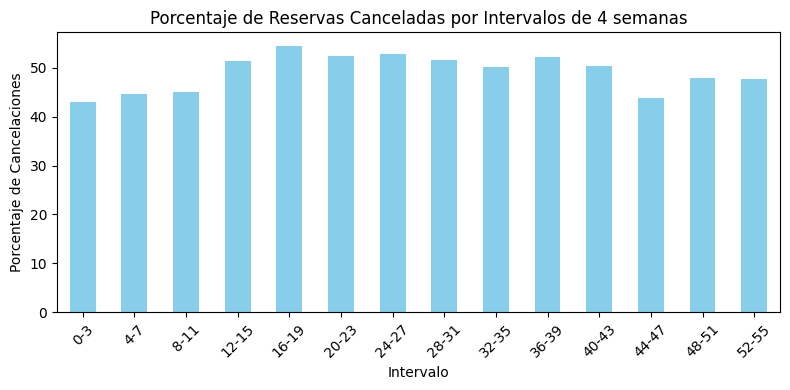

In [238]:
hotels_adwn_cancel_intervals = list(range(0, max(hotels_cancelations["arrival_date_week_number"].tolist()) + 5, 4))
hotels_adwn_cancel_labels = [f'{i}-{i+3}' for i in hotels_adwn_cancel_intervals[:-1]]

hotels_df['adwn_intervals'] = pd.cut(hotels_df['arrival_date_week_number'], bins=hotels_adwn_cancel_intervals, labels=hotels_adwn_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['adwn_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['adwn_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 4))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Intervalos de 4 semanas')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

Como puede observarse, no hay una diferencia particularmente apreciable, aunque hay fluctuaciones. Hay menos cancelaciones durante las primeras semanas del año, parecido a lo observado en arrival_date_month. Al momento de entrenar el modelo pareciera que el mes o el número de semana dan información bastante similar, guardando una relación con el **target**. 

#### arrival_date_day_of_month

En un principio, podría pensarse que continúa la misma línea de pensamiento que el parámetro anterior, pero lo mejor es investigar más ya que podría suceder que cambie según si es el comienzo, la mitad o el final del mes. Es una **Variable Independiente Cuantitativa Discreta**, ya que es una variable de tiempo discretizada.

Se propone calcular las medidas de resumen:

In [239]:
parameter_column = hotels_df['arrival_date_day_of_month'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  15.785812349587324
Mediana:  16.0
Varianza:  77.35936972151046
Desviación Estandar:  8.79541754105571
Moda:  17
Covarianza (con respecto a target):  -0.03241407010888681
Correlación de Pearson (con respecto a target):  -0.007370554150145503


A partir de los datos proporcionados, no parece que haya una relación clara, incluso la Correlación de Pearson dió negativa y cercana a 0, lo que significaría que no hay una relación estrecha con la variable **target**.

Se propone mostrar esto en un gráfico de tipo Histograma:

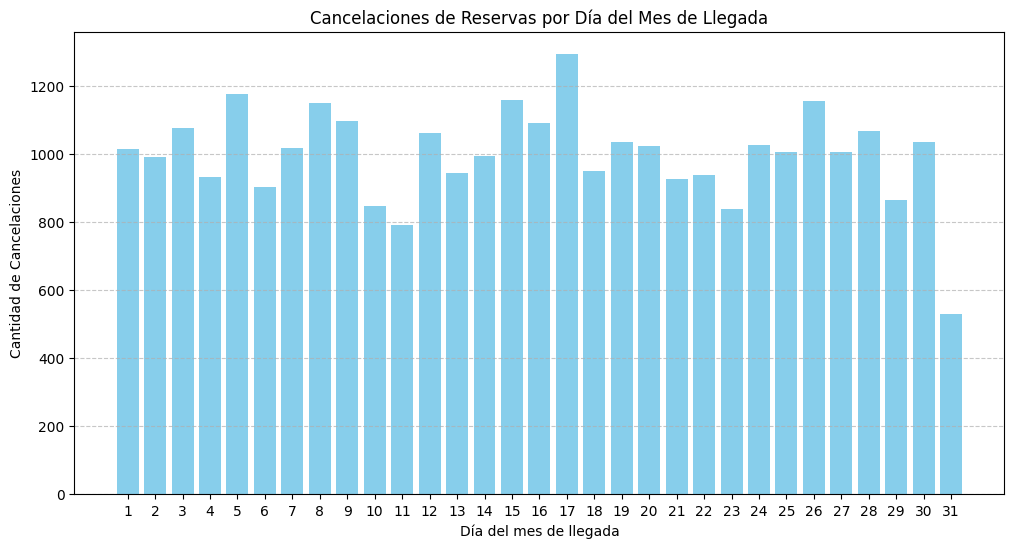

In [240]:
cancelations_by_day = hotels_cancelations['arrival_date_day_of_month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(cancelations_by_day.index, cancelations_by_day.values, color='skyblue')
plt.xlabel('Día del mes de llegada')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cancelaciones de Reservas por Día del Mes de Llegada')
plt.xticks(range(1, 32)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Se propone mostrar ahora con porcentajes:

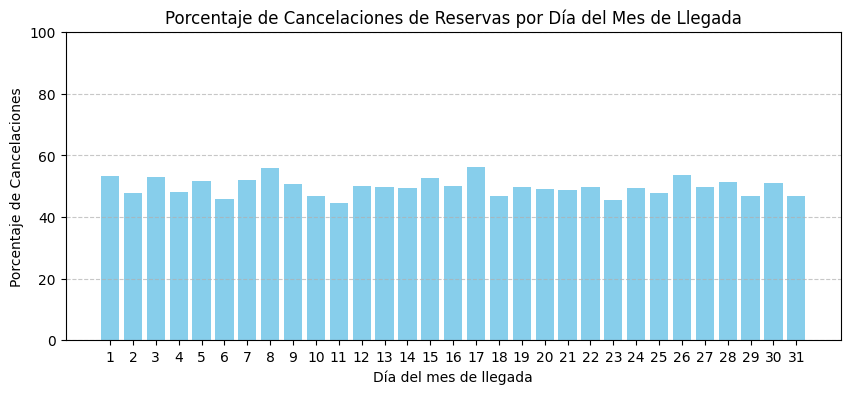

In [241]:
total_reservations_by_day = hotels_df['arrival_date_day_of_month'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_day = cancelled_reservations['arrival_date_day_of_month'].value_counts().sort_index()

percentages = (cancelations_by_day / total_reservations_by_day) * 100

plt.figure(figsize=(10, 4))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Día del mes de llegada')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por Día del Mes de Llegada')
plt.xticks(range(1, 32))
plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ahora, es aún más claro que el porcentaje no cambia en el tiempo. Por lo que se puede concluir que este parámetro es **irrelevante** para el entrenamiento del modelo y no guarda una relación estrecha con el **target**

#### stays_in_weekend_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. Se propone, tal y como antes, las medidas de resumen: 

In [242]:
parameter_column = hotels_df['stays_in_weekend_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.9241354804322194
Mediana:  1.0
Varianza:  0.986233333089822
Desviación Estandar:  0.9930928119213339
Moda:  0
Covarianza (con respecto a target):  0.0006351611956761096
Correlación de Pearson (con respecto a target):  0.0012791372744576411


No parece que haya un relación clara con respecto al **target**, pero se propone graficar el total de reservas canceladas según la cantidad de noches de fin de semana y el porcentaje de cancelaciones para cada valor posible:

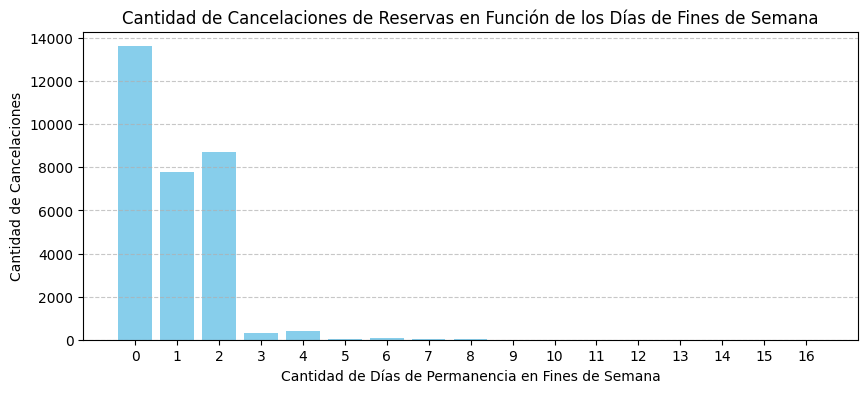

In [243]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_weekend_nights = cancelled_reservations['stays_in_weekend_nights'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(cancelations_by_weekend_nights.index, cancelations_by_weekend_nights.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Fines de Semana')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones de Reservas en Función de los Días de Fines de Semana')
plt.xticks(range(max(cancelations_by_weekend_nights.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como se puede observar, la mayoría de la gente no reserva más de noches de fin de semana, por lo que esto se debe tener en cuenta a la hora de decidir si vale la pena tener en cuenta este parámetro. Para el caso de los porcentajes:

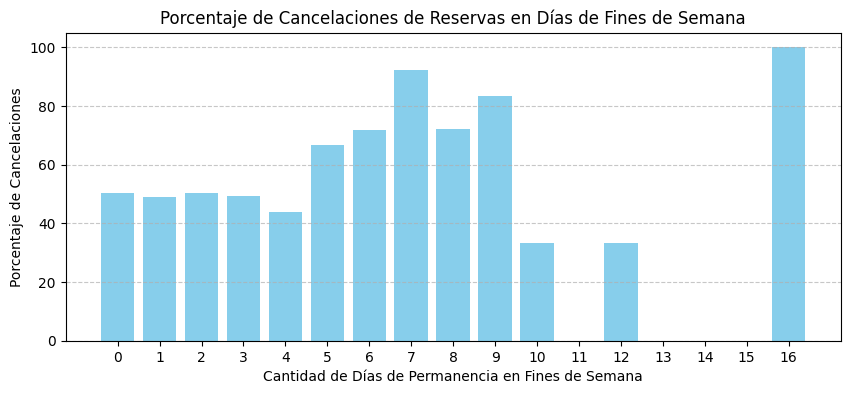

In [244]:
total_reservations_by_weekend_nights = hotels_df['stays_in_weekend_nights'].value_counts().sort_index()
percentages = (cancelations_by_weekend_nights / total_reservations_by_weekend_nights) * 100

plt.figure(figsize=(10, 4))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Fines de Semana')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas en Días de Fines de Semana')
plt.xticks(range(max(percentages.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podría pensarse que hay una variación muy grande, pero la realidad es que en comparación más de 4 noches de fin de semana ya no importan realmente en comparación con los demás.

Por lo que, para finalizar, el **target** no tiene una relación tan fuerte con esta variable, y se puede considerar **irrelevante** para el entrenamiento del modelo.

#### stays_in_week_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. En principio, podría pensarse que continúa con la misma lógica del parámetro anterior, por esto se propone investigar un poco más. Tal y como se hizo antes, se presentan las medidas de resumen: 

In [245]:
parameter_column = hotels_df['stays_in_week_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2.5100544312179993
Mediana:  2.0
Varianza:  3.5528885874786686
Desviación Estandar:  1.884910763797233
Moda:  2
Covarianza (con respecto a target):  0.026802652857020933
Correlación de Pearson (con respecto a target):  0.028438718504006387


En principio, no parecería tener una relación tan fuerte con el **target**.

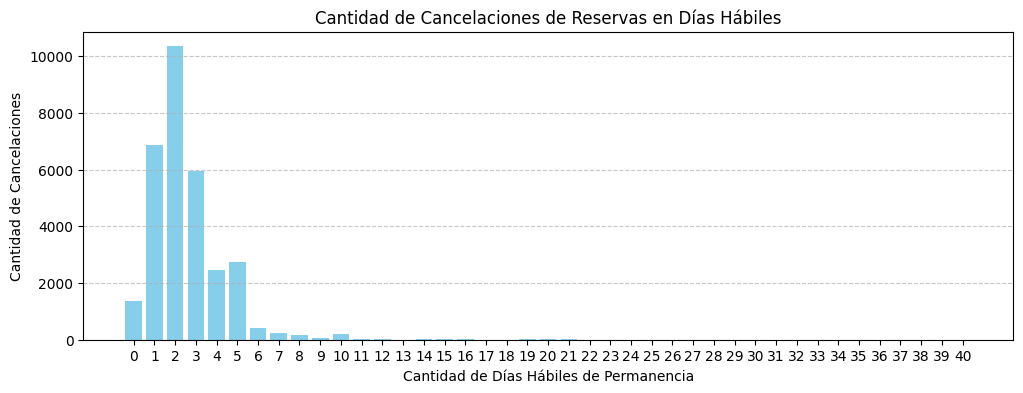

In [246]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_week_nights = cancelled_reservations['stays_in_week_nights'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
plt.bar(cancelations_by_week_nights.index, cancelations_by_week_nights.values, color='skyblue')
plt.xlabel('Cantidad de Días Hábiles de Permanencia')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones de Reservas en Días Hábiles')
plt.xticks(range(max(cancelations_by_week_nights.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como puede observarse, la mayor cantidad de datos importan hasta aproximadamente el día 10, luego son realmente muy pocos los datos que se tienen en comparación. Se propone ahora mostrar por porcentajes:

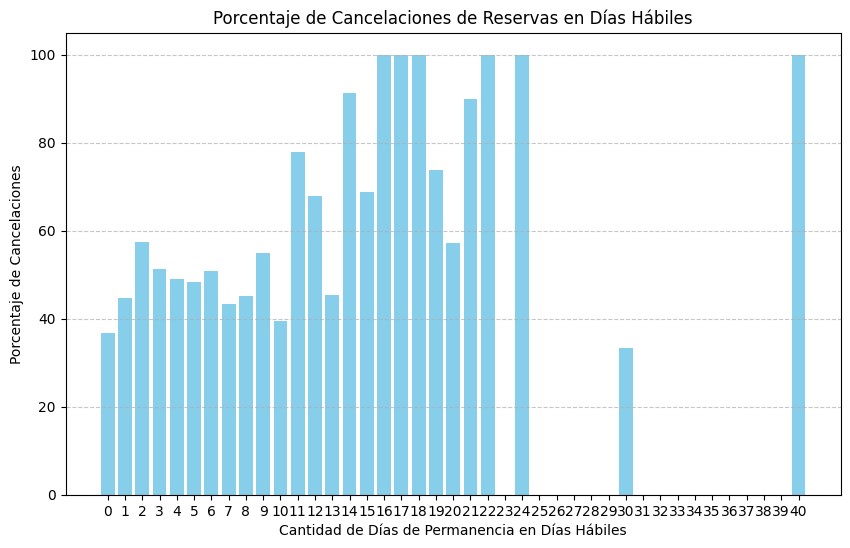

In [247]:
total_reservations_by_week_nights = hotels_df['stays_in_week_nights'].value_counts().sort_index()
percentages = (cancelations_by_week_nights / total_reservations_by_week_nights) * 100

plt.figure(figsize=(10, 6))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Días Hábiles')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas en Días Hábiles')
plt.xticks(range(max(percentages.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Hasta el día 10 no se ve un cambio demasiado profundo, pero a partir de ese día ya el cambio es mayor. Dado que no se tienen una cantidad de datos comparables a partir de dicha cantidad de días, es **irrelevante** considerar esta variable, aunque vale la pena aclarar que sí tiene una relación con el **target**, lo que sucede es que resulta lo mejor despreciarla ya que no se tienen tantas reservas a partir del día 10.

#### adults

El número de adultos podría llegar a ser una variable relevante, teniendo en cuenta que a mayor cantidad de adultos, resulta más dificil planificar un viaje y esto podría llevar a que se cancele la reserva.

 Este parámetro es una **Variable Independiente Cuantitativa Discreta**, por lo que se propone calcular las medidas de resumen:

In [248]:
parameter_column = hotels_df['adults'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  1.862791336229871
Mediana:  2.0
Varianza:  0.34699356195423825
Desviación Estandar:  0.589061594363644
Moda:  2
Covarianza (con respecto a target):  0.017724726478090883
Correlación de Pearson (con respecto a target):  0.060178570747318826


En general el promedio es de 2 personas adultas, por lo que la mayor cantidad de reservas probablemente se den para parejas. Tampoco se ve que haya una relación tan fuerte con el **target**. Se propone mostrar un gráfico de barras para observar la cantidad de reservas en función de la cantidad de adultos:

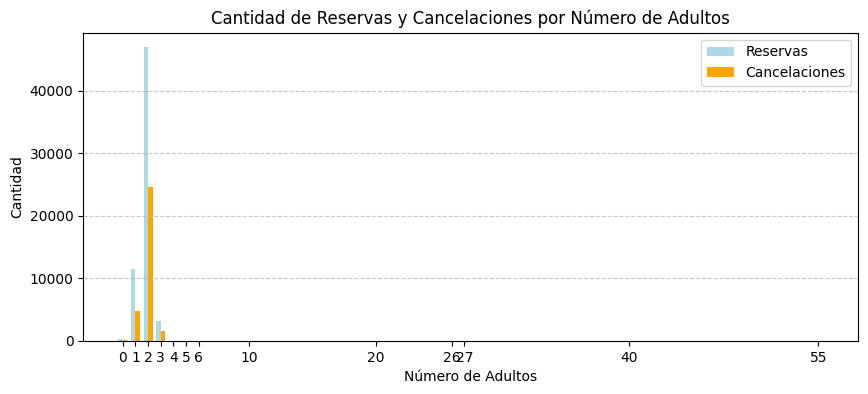

In [249]:
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
bar_width = 0.35
index = reservations_by_adults.index

plt.bar(index, reservations_by_adults, bar_width, label='Reservas', color='lightblue')
plt.bar(index + bar_width, cancelations_by_adults, bar_width, label='Cancelaciones', color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Cantidad')
plt.title('Cantidad de Reservas y Cancelaciones por Número de Adultos')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como se puede observar, hasta más de 4 adultos parece despreciable la estadística. Incluso se podría llegar a pensar que hay algunos valores atípicos, outliers, dado que resulta bastante extraño pensar en una reserva para 55 adultos salvo que sea un viaje de excursión o algo del estilo. Se propone limitar el gráfico hasta 6 adultos para poder verlo mejor.

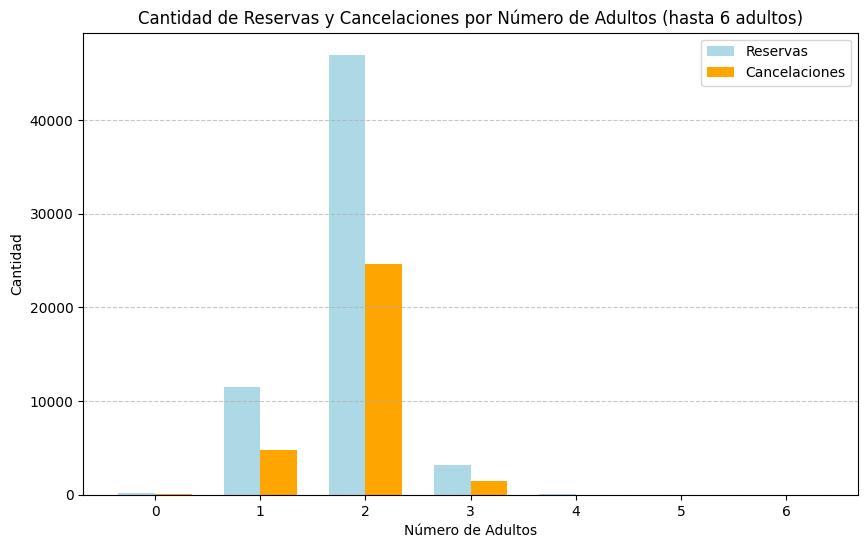

In [250]:
hotels_df['adults'] = hotels_df['adults'].clip(upper=6)
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = reservations_by_adults.index

plt.bar(index, reservations_by_adults, bar_width, label='Reservas', color='lightblue')
plt.bar(index + bar_width, cancelations_by_adults, bar_width, label='Cancelaciones', color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Cantidad')
plt.title('Cantidad de Reservas y Cancelaciones por Número de Adultos (hasta 6 adultos)')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ahora los números son más claros y parece que la mayor cantidad de reservas/cancelaciones se encuentran hasta 3 adultos. Incluso se ve que hay un pequeño porcentaje de 0 adultos, lo cual también parece extraño y podrían ser valores atípicos que deberán ser estudiados más adelante. Para poder comparar mejor, se muestran ahora con porcentajes:

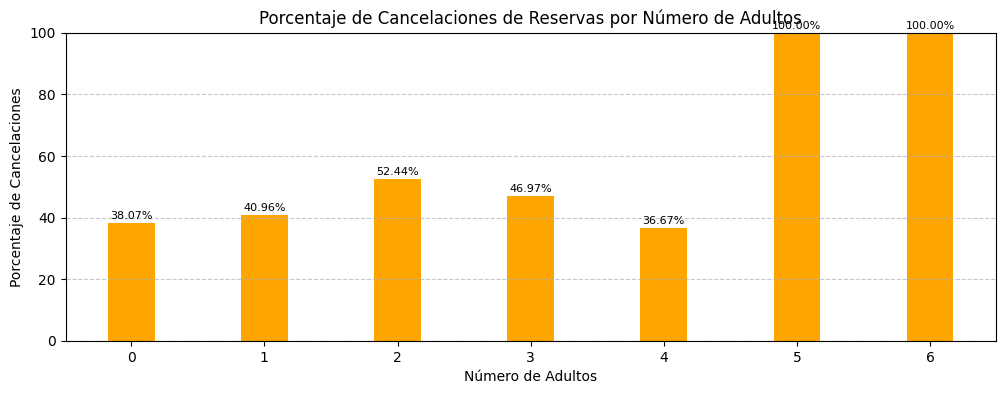

In [251]:
total_reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()
percentages = (cancelations_by_adults / total_reservations_by_adults) * 100

plt.figure(figsize=(12, 4))
bar_width = 0.35
index = percentages.index
bars = plt.bar(index, percentages.values, bar_width, color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por Número de Adultos')
plt.xticks(index)
plt.ylim(0, 100)

for bar, percentage in zip(bars, percentages.values):
    plt.annotate(f'{percentage:.2f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center',
                 fontsize=8,
                 color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Al observar detenidamente, se puede apreciar que hay una diferencia de un 10% en las cancelaciones al aumentar el número de adultos de 1 a 2, y un valor intermedio al ser 3, pero sigue siendo mayor que 1, aunque no por mucho. Esto seguramente se deba a que es más dificil acordar con más personas que viajar solo. Es tan así, que para 5 y 6 personas el porcentaje de cancelación alcanza el 100%.

Se concluye que es **relevante** para el entrenamiento del modelo y que guarda una relación con el **target**.

#### children

En cuanto a análisis, este parámetro resulta similar al de _adults_, pero es una variable dependiente, ya que los niños no deberían poder viajar solos y mucho menos quedarse en un hotel sin permiso de sus padres. En este caso es una **Variable Dependiente Cuantitativa Discreta**.

Se propone, al igual que en otras ocasiones, tomar medidas de resumen:

In [252]:
# Dado que hay muchos NaN, se propone reemplazarlos con 0 para obtener las medidas de resumen, ya que si no los resultados arrojan NaN
hotels_df['babies'].fillna(0, inplace=True)
hotels_df['babies'].replace("nan", 0)

parameter_column = hotels_df['children'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  nan
Mediana:  nan
Varianza:  nan
Desviación Estandar:  nan
Moda:  0.0
Covarianza (con respecto a target):  nan
Correlación de Pearson (con respecto a target):  nan


Por lo general, los adultos viajan sin hijos. Vale aclarar que se reemplazaron los valores NaN con 0, ya que si no arrojaban resultados NaN. No parece haber una relación muy fuerte con respecto a target.

Se propone mostrar en un gráfico de torta, los porcentajes de cancelación de personas con hijos y de personas sin hijos.

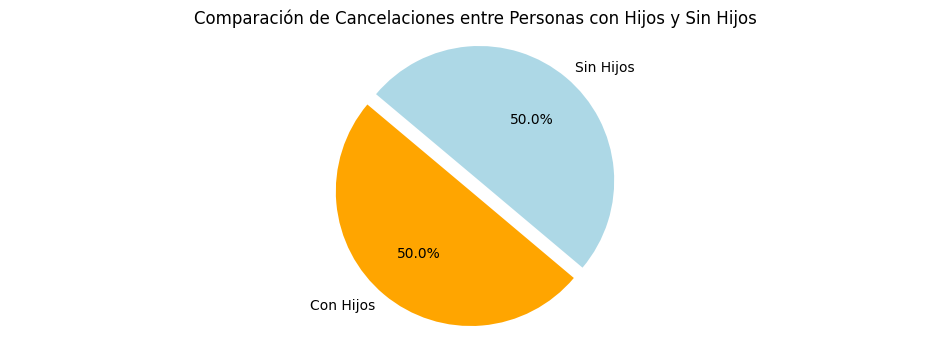

In [253]:
cancelations_by_children = hotels_cancelations['children'].value_counts().sort_index()
total_reservations_by_children = hotels_df['children'].value_counts().sort_index()
total_reservations_with_children = total_reservations_by_children.sum()
total_cancelations_with_children = cancelations_by_children.sum()
percentage_cancelations_with_children = (total_cancelations_with_children / total_reservations_with_children) * 100

reservations_without_children = hotels_df[hotels_df['children'] == 0]
cancelations_without_children = reservations_without_children[reservations_without_children['is_canceled'] == 1]
total_reservations_without_children = len(reservations_without_children)
total_cancelations_without_children = len(cancelations_without_children)
percentage_cancelations_without_children = (total_cancelations_without_children / total_reservations_without_children) * 100

plt.figure(figsize=(12, 4))
labels = ['Con Hijos', 'Sin Hijos']
sizes = [percentage_cancelations_with_children, percentage_cancelations_without_children]
colors = ['orange', 'lightblue']
explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.axis('equal') 
plt.title('Comparación de Cancelaciones entre Personas con Hijos y Sin Hijos')
plt.show()

hotels_df = hotels_df_backup.copy()

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con hijos o sin hijos, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan hijos. Esto significa que no está relacionado con el **target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson. 

#### babies

En cuanto a análisis, este parámetro resulta similar al de _children_, pero es una variable dependiente, ya que los bebes no deberían poder viajar solos nunca, si no acompañados de sus padres, y mucho menos quedarse en un hotel. En este caso es una **Variable Dependiente Cuantitativa Discreta**.

Se propone calcular las medidas de resumen:

In [254]:
# Dado que hay muchos NaN, se propone reemplazarlos con 0 para obtener las medidas de resumen, ya que si no los resultados arrojan NaN
hotels_df['babies'].fillna(0, inplace=True)
hotels_df['babies'].replace("nan", 0)

parameter_column = hotels_df['babies'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.007155201653933746
Mediana:  0.0
Varianza:  0.008493050662499106
Desviación Estandar:  0.09215774879248682
Moda:  0
Covarianza (con respecto a target):  -0.0014761127790147972
Correlación de Pearson (con respecto a target):  -0.0320339665770838


Este caso es aún más evidente que el anterior, no guardan ninguna relación con la variable **target**, se propone realizar el mismo procedimiento de comparación que antes:

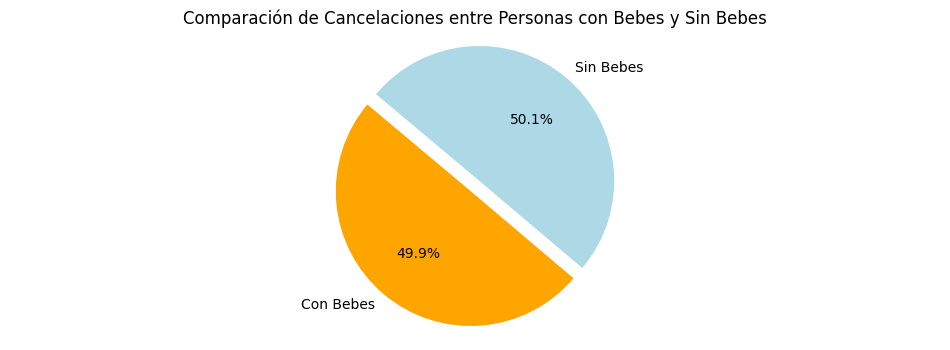

In [255]:
cancelations_by_babies = hotels_cancelations['babies'].value_counts().sort_index()
total_reservations_by_babies = hotels_df['babies'].value_counts().sort_index()
total_reservations_with_babies = total_reservations_by_babies.sum()
total_cancelations_with_babies = cancelations_by_babies.sum()
percentage_cancelations_with_babies = (total_cancelations_with_babies / total_reservations_with_babies) * 100

reservations_without_babies = hotels_df[hotels_df['babies'] == 0]
cancelations_without_babies = reservations_without_babies[reservations_without_babies['is_canceled'] == 1]
total_reservations_without_babies = len(reservations_without_babies)
total_cancelations_without_babies = len(cancelations_without_babies)
percentage_cancelations_without_babies = (total_cancelations_without_babies / total_reservations_without_babies) * 100

plt.figure(figsize=(12, 4))
labels = ['Con Bebes', 'Sin Bebes']
sizes = [percentage_cancelations_with_babies, percentage_cancelations_without_babies]
colors = ['orange', 'lightblue']
explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.axis('equal') 
plt.title('Comparación de Cancelaciones entre Personas con Bebes y Sin Bebes')
plt.show()

hotels_df = hotels_df_backup.copy()

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con bebes o sin bebes, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan bebes. Esto significa que no está relacionado con el **target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson. 

#### meal

El parámetro indica la comida reservada, no parece en principio una decisión que vaya a influir en la decisión de cancelar una reserva. Dado que es una **Variable Independiente Cualitativa Texto Nominal**, por lo que se reportarán los valores más frecuentes.

In [256]:
hotels_df['meal'] = hotels_df['meal'].replace('Undefined', 'SC')
meal_counts = hotels_df['meal'].value_counts()

print(meal_counts)

meal
BB    47837
HB     7452
SC     6147
FB      477
Name: count, dtype: int64


Como se puede observar, la comida más pedida es Bed & Breakfast, vale aclarar que Undefined y SC implican que no se solicitó ninguna comida, por lo que en realidad ambos suman una única categoría.

De todas maneras, se propone mostrar el porcentaje de cancelación dependiendo cada categoría, en un gráfico de barras:

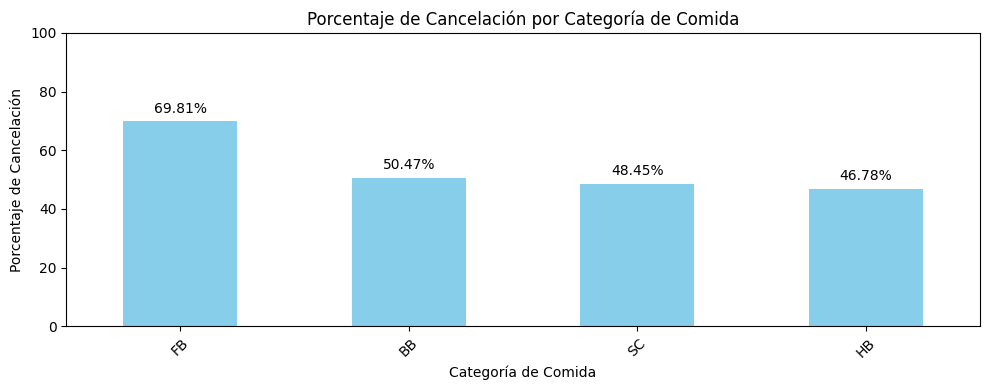

In [257]:
total_reservas_por_comida = hotels_df['meal'].value_counts()
reservas_canceladas_por_comida = hotels_df[hotels_df['is_canceled'] == 1]['meal'].value_counts()
porcentaje_cancelacion_por_comida = (reservas_canceladas_por_comida / total_reservas_por_comida) * 100
porcentaje_cancelacion_por_comida = porcentaje_cancelacion_por_comida.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
ax = porcentaje_cancelacion_por_comida.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Cancelación por Categoría de Comida')
plt.xlabel('Categoría de Comida')
plt.ylabel('Porcentaje de Cancelación')
plt.ylim(0, 100)
plt.xticks(rotation=45)

for i, v in enumerate(porcentaje_cancelacion_por_comida):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

En un principio, podría pensarse que no guardan relación con la variable **target**, pero al arrojar los siguientes resultados se ve que podría existir ya que el porcentaje de cancelación es el mismo para BB (Bed & Breakfast), SC (No Meal Package) y HB (Half Board), pero para FB (Full Board) hay un 20% más de cancelaciones. Es posible que esto se deba a que el presupuesto es mayor y tal vez la gente no cuenta con ese dinero al momento y decide cancelar, estas razones se desconocen por lo que habría que investigar más. Pero es clara la relación, por lo que se define como un parámetro **relevante** a la hora de entrenar el modelo.

#### country

El parámetro es de tipo **Variable Independiente Cualitativa Texto Nominal** ya que es una categoría, son países. En un principio, sería normal pensar que dependiendo el país haya más o menos cancelaciones de reservas puesto que la cultura influye mucho en la toma de decisiones. Se propone mostrar un gráfico de torta con los porcentajes de reserva de cada país y luego un gráfico con los porcentajes de cancelaciones. 

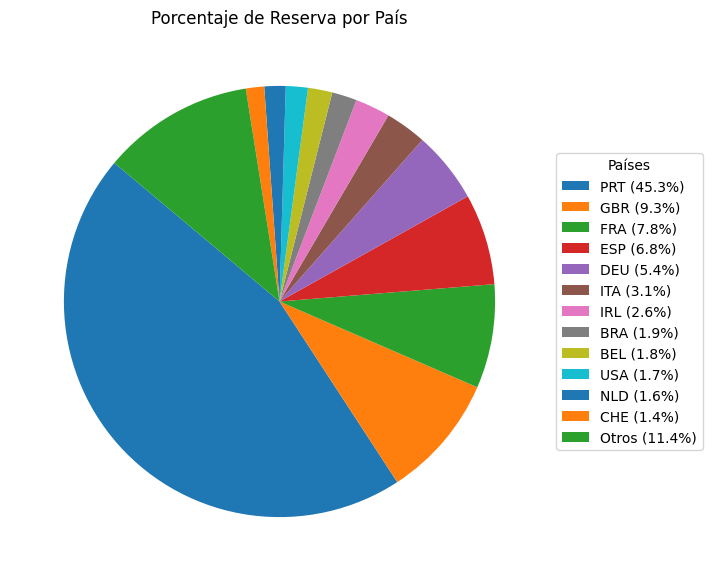

In [258]:
porcentajes_reserva_por_pais = hotels_df['country'].value_counts(normalize=True) * 100

# Filtro países con un porcentaje mayor al 1% y agrupar los demás en "Otros"
umbral = 1
porcentajes_reserva_por_pais = porcentajes_reserva_por_pais[porcentajes_reserva_por_pais > umbral]
porcentajes_reserva_por_pais['Otros'] = 100 - porcentajes_reserva_por_pais.sum()

plt.figure(figsize=(7, 7))
wedges = plt.pie(porcentajes_reserva_por_pais, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_pais.index, porcentajes_reserva_por_pais)]
plt.legend(leyenda_personalizada, title="Países", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Porcentaje de Reserva por País')
plt.show()

Como se puede observar, la mayor parte de las reservaciones provienen de Portugal (PRT), luego de Reino Unido (GBR), de Francia (FRA), España (ESP) y Alemania (DEU). Luego, los demás países en menor medida.

A continuación, se muestra en un gráfico de barras el porcentaje de cancelaciones por país:

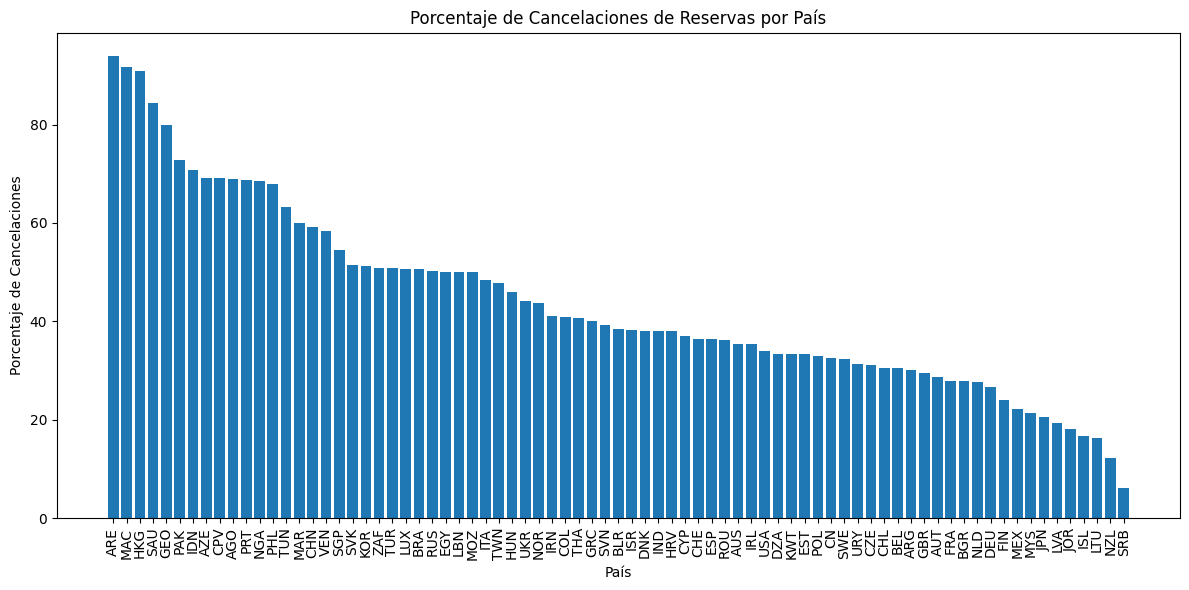

In [259]:
country_counts = hotels_df['country'].value_counts()
countries_with_more_than_10_reservations = country_counts[country_counts > 10].index
filtered_df = hotels_df[hotels_df['country'].isin(countries_with_more_than_10_reservations)]
cancelation_percentages = (filtered_df.groupby('country')['is_canceled'].mean() * 100).reset_index()
cancelation_percentages = cancelation_percentages.sort_values(by='is_canceled', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(cancelation_percentages['country'], cancelation_percentages['is_canceled'])
plt.xlabel('País')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por País')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

hotels_df = hotels_df_backup.copy()

Como puede observarse en el gráfico, el porcentaje de cancelación posee un porcentaje de variación muy alto dependiendo el país. Vale aclarar que se muestran países con una cantidad mayor a 10 reservas, ya que en caso contrario el gráfico era demasiado extenso y tampoco se tenía una cantidad de datos apreciable como para tener un porcentaje fiable.  
Además, como puede apreciarse, PRT (Portugal) es el país con mayor cantidad de reservas, pero no cancelaciones. Sin embargo, ARE (Emiratos Arabes Unidos), tiene menos del 1% de reservas, pero aún así guarda una tasa de cancelaciones muy alta. SRB (Serbia), por otro lado, posee pocas reservas, pero una tasa de no cancelación muy baja. 

Es más que claro que es **relevante** para el entrenamiento del modelo y guarda un estrecha relación con el **target**.

#### market_segment

Este parámetr sirve para segmentar el mercado en grupos más pequeños y homogéneos de consumidores o empresas que comparten características similares. Es una **Variable Independiente Cualitativa Texto Nominal**, por lo que se mostrarán sus valores más frecuentes y otros de interés.

En principio, podría resultar útil analizar su relación con el **target**, debido a que es un parámetro pensado para segmentar las reservas.

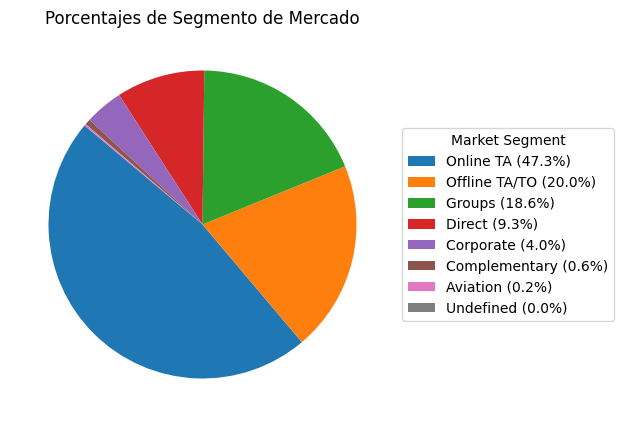

In [260]:
porcentajes_reserva_por_dc = hotels_df['market_segment'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 5))
wedges = plt.pie(porcentajes_reserva_por_dc, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_dc.index, porcentajes_reserva_por_dc)]
plt.legend(leyenda_personalizada, title="Market Segment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Porcentajes de Segmento de Mercado')
plt.show()

Como se puede observar, la mayor parte de las reservas provienen de TA Online, luego de Offline TA/TO, seguido por Groups y luego por Direct. Finalmente, los demás en menor medida. Undefined indicaría que habría que revisar dichos valores.

Se propone ahora analizar su relación con target en un gráfico de barras porcentuales con respecto a la cantidad de cancelaciones:

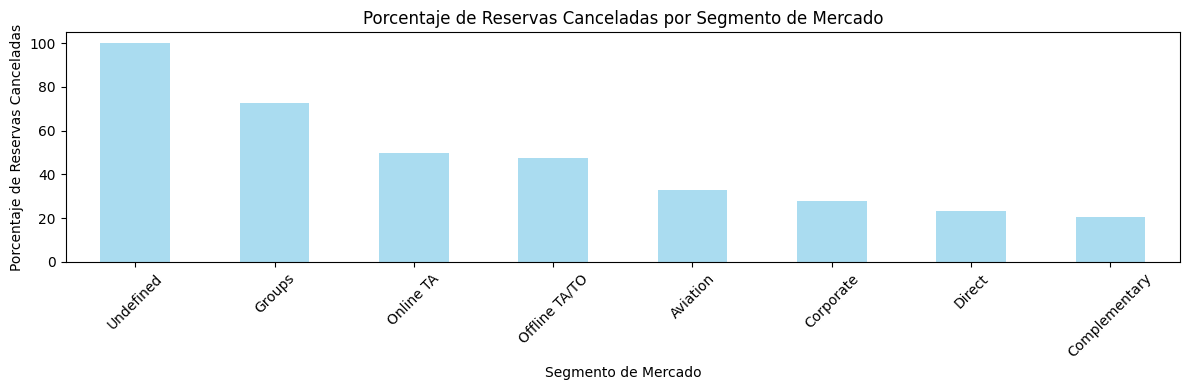

In [261]:
segment_cancelation_percentage = hotels_df.groupby('market_segment')['is_canceled'].mean() * 100
segment_cancelation_percentage = segment_cancelation_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
segment_cancelation_percentage.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Porcentaje de Reservas Canceladas por Segmento de Mercado')
plt.xlabel('Segmento de Mercado')
plt.ylabel('Porcentaje de Reservas Canceladas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como se puede observar, hay mucha diferencia según el grupo, por lo que está fuertemente relacionada con la variable **target** y es **relevante** para el entrenamiento del modelo.

#### distribution_channel

Este parámetro sigue la misma lógica de análisis que el anterior, es una **Variable Independiente Cualitativa Texto Nominal**, por lo que se propone reportar los valores que toman y cuán frecuentemente lo hacen.

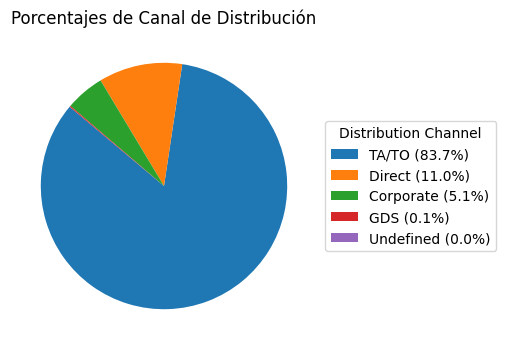

In [262]:
porcentajes_reserva_por_dch = hotels_df['distribution_channel'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 4))
wedges, labels = plt.pie(porcentajes_reserva_por_dch, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_dch.index, porcentajes_reserva_por_dch)]
plt.legend(leyenda_personalizada, title="Distribution Channel", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Porcentajes de Canal de Distribución')
plt.show()

Claramente, se puede apreciar que la mayor parte de las reservas provienen de TA/TO, luego de Direct y finalmente de Corporate. Por último, de GDS y Undefined. Se propone verificar los porcentajes de cancelación en un gráfico de barras para estudiar su relación con target.

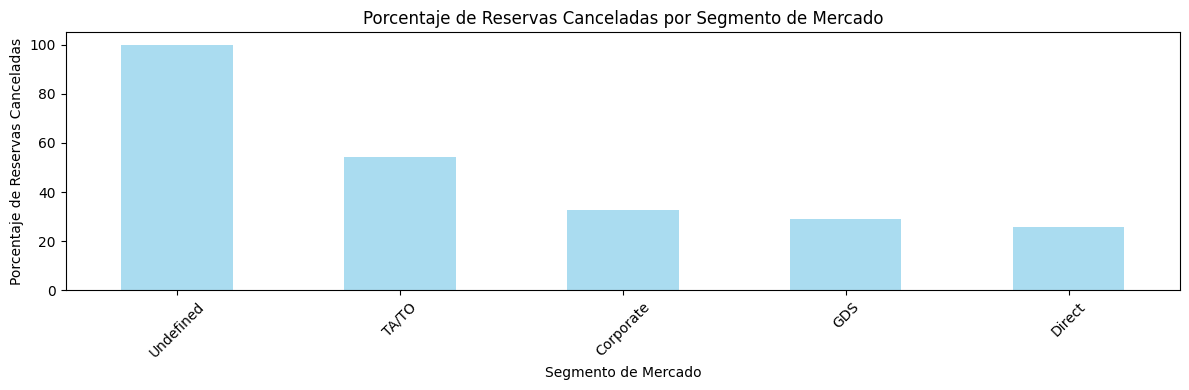

In [263]:
dc_cancelation_percentage = hotels_df.groupby('distribution_channel')['is_canceled'].mean() * 100
dc_cancelation_percentage = dc_cancelation_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
dc_cancelation_percentage.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Porcentaje de Reservas Canceladas por Segmento de Mercado')
plt.xlabel('Segmento de Mercado')
plt.ylabel('Porcentaje de Reservas Canceladas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sin tener en cuenta "Undefined", se puede apreciar un porcentaje mucho mayor de cancelación de TA/TO (Travel Agent) con respecto a los demás. Por lo que se puede afirmar que guarda una relación estrecha con **target** y es **relevante**.

#### is_repeated_guest

Este parámetro indica si el cliente ha visitado el hotel en el pasado o no. Es una **Variable Independiente Cuantitativa Numérica Nominal**, que es un valor binario, que indica 1 como _true_ y 0 como _false_.

Se propone buscar la relación con las cancelaciones y el porcentaje de clientes repetidos.

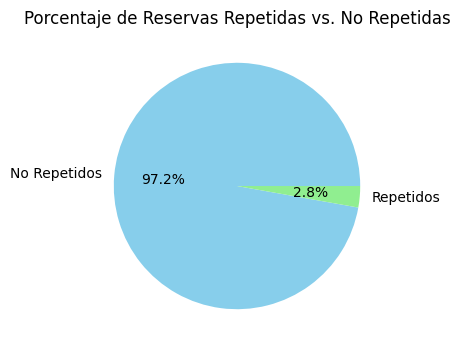

In [264]:
guest_counts = hotels_df['is_repeated_guest'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(guest_counts, labels=['No Repetidos', 'Repetidos'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Porcentaje de Reservas Repetidas vs. No Repetidas')
plt.show()

El porcentaje de visitantes Repetidos es mucho menor al de No Repetidos, pero esto no significa que no deba tenerse en cuenta. Se propone investigar su relación con la variable target:

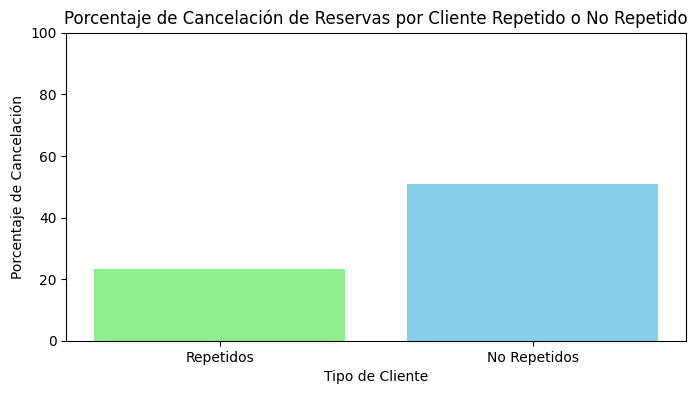

In [265]:
repeated_guests_df = hotels_df[hotels_df['is_repeated_guest'] == 1]
non_repeated_guests_df = hotels_df[hotels_df['is_repeated_guest'] == 0]
cancelation_percentage_repeated = (repeated_guests_df['is_canceled'].mean()) * 100
cancelation_percentage_non_repeated = (non_repeated_guests_df['is_canceled'].mean()) * 100
categories = ['Repetidos', 'No Repetidos']
cancelation_percentages = [cancelation_percentage_repeated, cancelation_percentage_non_repeated]

plt.figure(figsize=(8, 4))
plt.bar(categories, cancelation_percentages, color=['lightgreen', 'skyblue'])
plt.ylim(0, 100)
plt.title('Porcentaje de Cancelación de Reservas por Cliente Repetido o No Repetido')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Porcentaje de Cancelación')
plt.show()

Como puede observarse, es mucho menor la probabilidad de que un cliente que ya vino al hotel cancele su reserva a que lo haga uno que no repitió. Entonces, el parámetro es **relevante** y guarda una relación estrecha con el parámetro **target**.

#### previous_cancellations

Este parámetro es similar al anterior en cuanto análisis, es una **Variable Independiente Cualitativa Numérica Nominal**. Sería esperable que una persona que haya cancelado previamente, tenga la tendencia de hacerlo, aunque también podría suceder que al haber cancelado previamente, no quiera volver a hacerlo. Lo mejor será investigar un poco más este parámetro de forma similar al anterior parámetro.

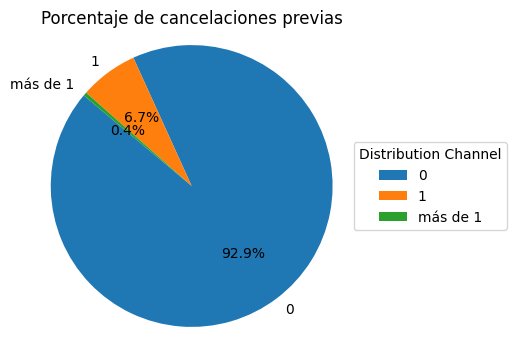

In [266]:
previous_cancellations = hotels_df['previous_cancellations'].copy()
previous_cancellations = previous_cancellations.apply(lambda x: x if x <= 1 else 'más de 1')
cancellation_counts = previous_cancellations.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend(title="Distribution Channel", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Porcentaje de cancelaciones previas')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Como puede observarse, la mayor parte de las cancelaciones no fueron canceladas o no fueron canceladas previamente al menos. Ahora se propone estudiar su relación con el target, teniendo en cuenta su relación con las cancelaciones, es decir, que porcentaje de las reservas canceladas fueron hechas por personas que cancelaron previamente y que porcentaje no.

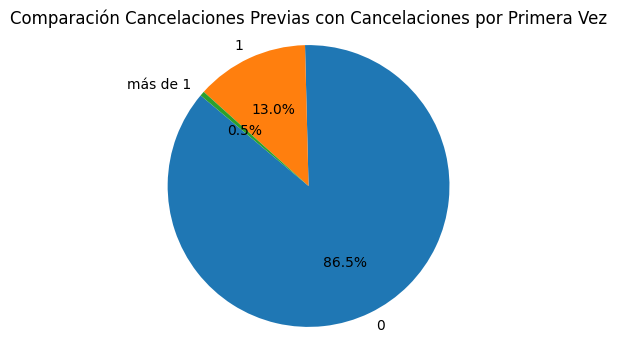

In [267]:
previous_cancellations = hotels_cancelations['previous_cancellations'].apply(lambda x: x if x <= 1 else 'más de 1')
cancellation_counts = previous_cancellations.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Comparación Cancelaciones Previas con Cancelaciones por Primera Vez')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

El porcentaje de cancelación de reservas sigue siendo mucho mayor si no habían reservado anteriormente, pero esto también se debe a que mucha gente que nunca había reservado en el hotel reserva por primera vez. Se propone entonces, comparar los porcentajes con respecto a clientes que ya habían visitado el hotel, con clientes que reservan por primera vez.

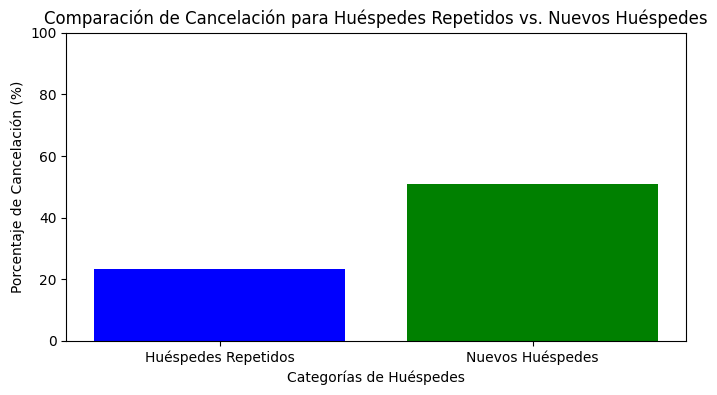

In [268]:
repeated_guests = hotels_df[hotels_df['is_repeated_guest'] != 0]
new_guests = hotels_df[hotels_df['is_repeated_guest'] == 0]
percentage_repeated_guest = (repeated_guests['is_canceled'].sum() / len(repeated_guests)) * 100
percentage_new_guest = (new_guests['is_canceled'].sum() / len(new_guests)) * 100

data = {'Porcentaje': [percentage_repeated_guest, percentage_new_guest]}
categorias = ['Huéspedes Repetidos', 'Nuevos Huéspedes']
df = pd.DataFrame(data, index=categorias)

plt.figure(figsize=(8, 4))
plt.bar(df.index, df['Porcentaje'], color=['blue', 'green'])
plt.xlabel('Categorías de Huéspedes')
plt.ylabel('Porcentaje de Cancelación (%)')
plt.title('Comparación de Cancelación para Huéspedes Repetidos vs. Nuevos Huéspedes')
plt.ylim(0, 100)
plt.show()

Como se puede observar, el porcentaje de cancelación de los huéspedes que ya visitaron el hotel es mucho menor a los nuevos huéspedes que nunca lo hicieron, esto puede deberse a que ya entablaron una relación con la gente del hotel, o tal vez se sienten más seguros y no quieren perder dicha relación u otra razón. Lo que sí es seguro, es que es un factor a tener en cuenta, es **relevante** para el entrenamiento del modelo, y además tiene un fuerte relación con el **target**.

#### previous_bookings_not_canceled

Este parámetro sigue una lógica similar al anterior, por lo que se plantea realizar un análisis análogo. Es una **Variable Independiente Cualitativa Numérica Nominal**

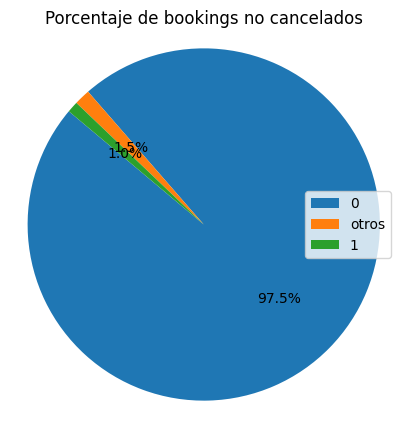

In [269]:
previous_cancellations = hotels_df['previous_bookings_not_canceled'].copy()
previous_cancellations = previous_cancellations.apply(lambda x: x if x <= 1 else 'otros')
cancellation_counts = previous_cancellations.value_counts()

plt.figure(figsize=(5, 5))
plt.pie(cancellation_counts, autopct='%1.1f%%', startangle=140)
plt.legend(cancellation_counts.index, loc="center right")
plt.title('Porcentaje de bookings no cancelados')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Se representa la cantidad de reservas previas que un cliente o grupo de clientes ha realizado en un hotel específico y que no fueron canceladas, es decir lo que indica el gráfico es que la gran mayoría de los clientes nunca realizó ninguna reserva, por consiguiente que es la primera vez que realiza una reserva. Si bien puede parecer similar al anterior parámetro, no lo es.

Se propone analizar los porcentajes de cancelación de aquellos clientes que nunca reservaron con respecto a los que alguna vez reservaron.

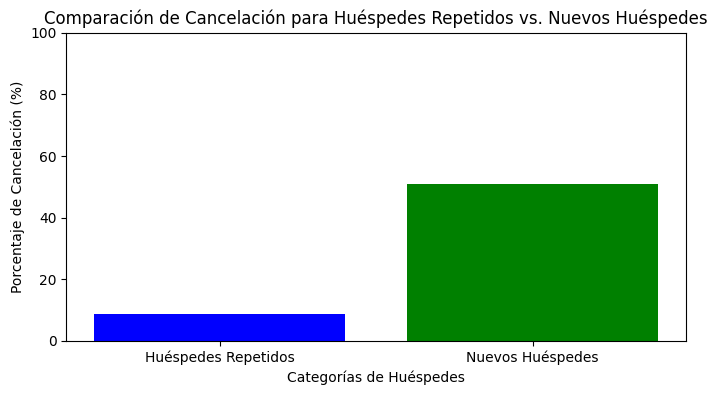

In [270]:
repeated_guests = hotels_df[hotels_df['previous_bookings_not_canceled'] != 0]
new_guests = hotels_df[hotels_df['previous_bookings_not_canceled'] == 0]
percentage_repeated_guest = (repeated_guests['is_canceled'].sum() / len(repeated_guests)) * 100
percentage_new_guest = (new_guests['is_canceled'].sum() / len(new_guests)) * 100

data = {'Porcentaje': [percentage_repeated_guest, percentage_new_guest]}
categorias = ['Huéspedes Repetidos', 'Nuevos Huéspedes']
df = pd.DataFrame(data, index=categorias)

plt.figure(figsize=(8, 4))
plt.bar(df.index, df['Porcentaje'], color=['blue', 'green'])
plt.xlabel('Categorías de Huéspedes')
plt.ylabel('Porcentaje de Cancelación (%)')
plt.title('Comparación de Cancelación para Huéspedes Repetidos vs. Nuevos Huéspedes')
plt.ylim(0, 100)
plt.show()

Es mucho más probable que un huesped que nunca reservó un booking cancele que uno que ya lo hice, esto puede deberse a que ya entabló una relación con el establecimiento o la companía y no quiere perderlo. Entonces, se puede deducir que es un parámetro **relevante** y está relacionado fuertemente con el **target**.

#### reserved_room_type

Este parámetro es una **Variable Independiente Cualitativa Nominal** que indica el tipo de cuarto reservado. A partir de dicho valor se propone investigar el porcentaje de reservas por cuarto y el porcentaje de cancelación dependiendo el cuarto reservado.

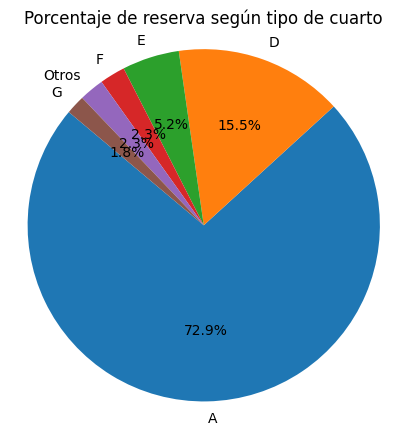

In [271]:
hotels_df_copy = hotels_df.copy()
reserved_room_type_counts = hotels_df_copy["reserved_room_type"].value_counts()
threshold = 0.01 * len(hotels_df_copy)
hotels_df_copy['reserved_room_type'] = hotels_df_copy['reserved_room_type'].apply(lambda x: x if reserved_room_type_counts[x] > threshold else 'Otros')
new_reserved_room_type_counts = hotels_df_copy['reserved_room_type'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(new_reserved_room_type_counts, labels=new_reserved_room_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Porcentaje de reserva según tipo de cuarto')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Como se puede apreciar, la mayor parte de las reservas eligen el cuarto A y tiene un costo menor, las otras reservas serán más caras a medida que la letra sea "mayor". Ahora su relación con respecto al target

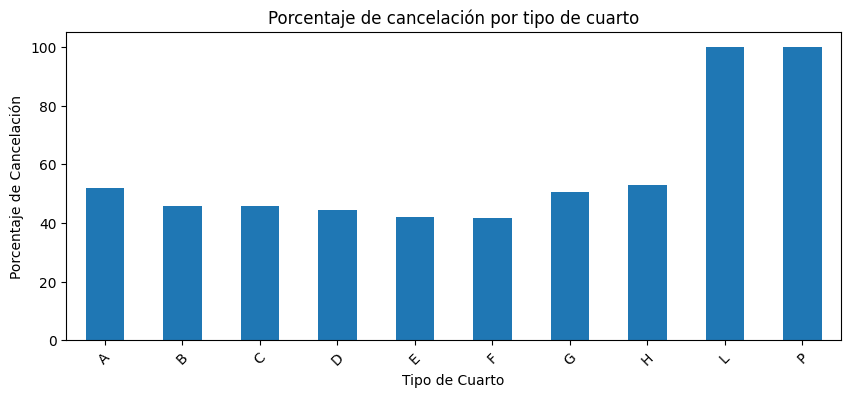

In [272]:
reserved_room_type_counts = hotels_df["reserved_room_type"].value_counts()
threshold = 0.01 * len(hotels_df)
cancellation_percentages = hotels_df.groupby('reserved_room_type')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación por tipo de cuarto')
plt.xlabel('Tipo de Cuarto')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=45)
plt.show()

hotels_df = hotels_df_backup.copy()

Si bien se puede apreciar cierta variación entre los cuartos, descargando los cuartos L y P, que probablemente sean Outliers (además de que poseen un porcentaje muy pequeño), no se ve una relación muy estrecha, por lo que se puede concluir que es **irrelevante** para el entrenamiento del modelo. Además, no posee una relación tan estrecha con el **target**.

#### assigned_room_type

Este parámetro indica el cuarto que efectivamente se asignó, a veces difiere del original, por lo que, se propone investigar la cantidad de cuartos que difieren entre el assigned_room_type y a partir de dicho dato, calcular la cantidad de cancelaciones. Es una **Variable Dependiente Cualitativa Texto Nominal**.

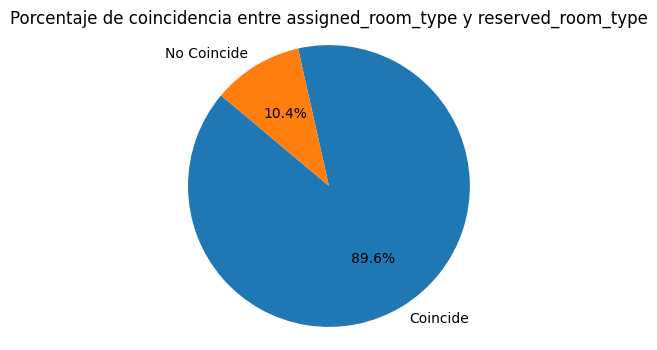

In [273]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['room_type_match'] = hotels_df_copy['assigned_room_type'] == hotels_df_copy['reserved_room_type']
match_counts = hotels_df_copy['room_type_match'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(match_counts, labels=['Coincide', 'No Coincide'], autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de coincidencia entre assigned_room_type y reserved_room_type')
plt.axis('equal')
plt.show()

El porcentaje de No Coincidencia es bastante alto (un 10%), por lo que podría suceder que al no asignar el cuarto esperado, el cliente cancele la reserva. Esto merece ser estudiado, tal que se compararán los porcentajes de cancelación de las coincidencias y las no coincidencias.

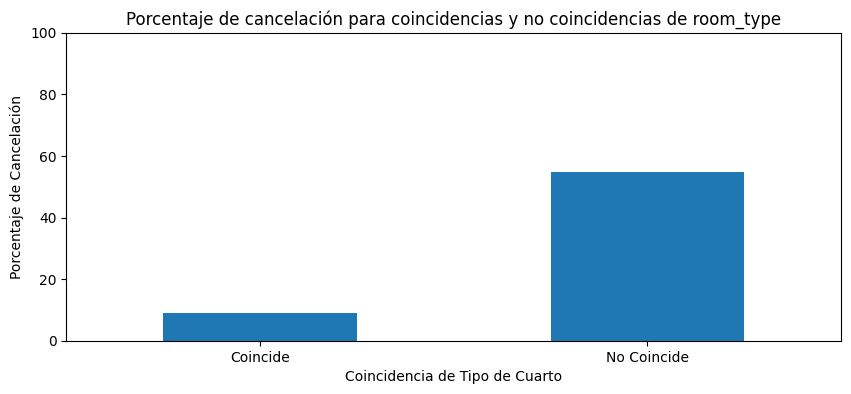

In [274]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['room_type_match'] = hotels_df_copy['assigned_room_type'] == hotels_df_copy['reserved_room_type']
cancellation_percentages = hotels_df_copy.groupby('room_type_match')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación para coincidencias y no coincidencias de room_type')
plt.xlabel('Coincidencia de Tipo de Cuarto')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks([0, 1], ['Coincide', 'No Coincide'], rotation=0)
plt.ylim(0, 100)
plt.show()

Ahora la relación es mucho más clara, cuando el cuarto no coincide con el asignado, el porcentaje de cancelación es casi del 60%, muchísimo menor al de coincidencia. De esta manera, queda claro que el parámetro es **relevante** para el entrenamiento del modelo, así mismo se ve su relación con la variable **target**.

#### booking_changes

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, tal que indica la cantidad de cambios realizados en el booking, por el cliente o la empresa. Se propone mostrar primero las proporciones de reservas que realizan cambios y las que no, y luego su relación con la variable target.

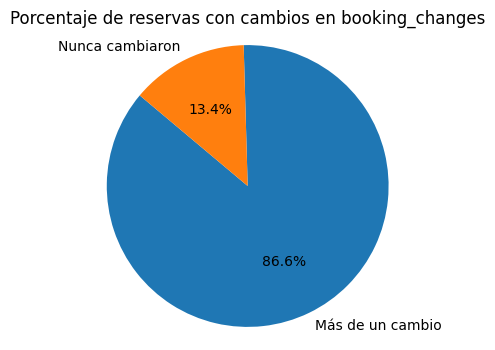

In [275]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['more_than_one_change'] = hotels_df_copy['booking_changes'] != 0
change_counts = hotels_df_copy['more_than_one_change'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(change_counts, labels=['Más de un cambio', 'Nunca cambiaron'], autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de reservas con cambios en booking_changes')
plt.axis('equal')
plt.show()

Se deduce entonces que la mayoría de las reservas sufren cambios, faltaría determinar si esos cambios son causales de cancelaciones de reservas.

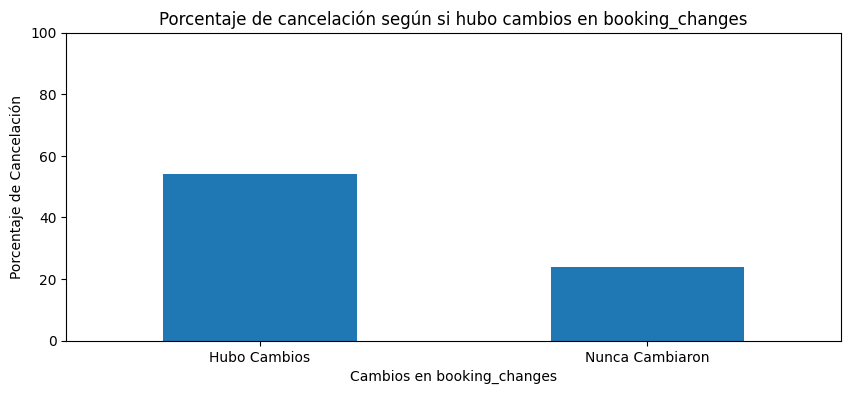

In [276]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['changes_occurred'] = hotels_df_copy['booking_changes'] > 0
cancellation_percentages = hotels_df_copy.groupby('changes_occurred')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación según si hubo cambios en booking_changes')
plt.xlabel('Cambios en booking_changes')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks([0, 1], ['Hubo Cambios', 'Nunca Cambiaron'], rotation=0)
plt.ylim(0, 100)
plt.show()

Evidentemente, cuanto más cambios hubo en el booking más probable fue que se cancele la reserva, lo cual tiene sentido lógico, ya que esto puede afectar al proyecto original que tenía dicha persona.

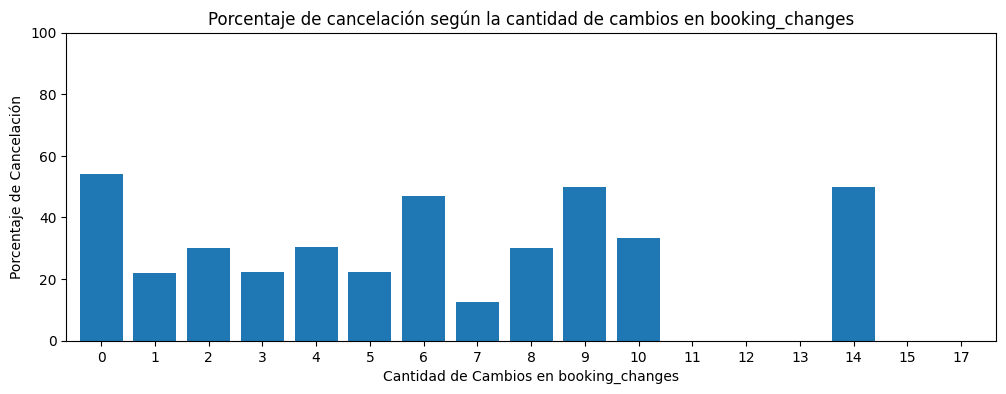

In [277]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('booking_changes')['is_canceled'].mean() * 100

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación según la cantidad de cambios en booking_changes')
plt.xlabel('Cantidad de Cambios en booking_changes')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

Ahora se realiza una investigación más precisa, dependiendo la cantidad de cambios. En este caso, se puede apreciar, que para pocos cambios el porcentaje de cancelación fue mucho menor, lo cual también tiene sentido ya que podría significar que debido a esos cambios, la persona puedo modificar su viaje para poder llevarlo a cabo.  
Este gráfico es mucho más específico, pero al mismo tiempo se desconoce si los cambios fueron debido a la companía de viajes o al cliente, por lo tanto lo mejor es tener en cuenta el anterior, es decir si hubo cambios o no. Si hubo cambios será más probable que se cancele la reserva que si no los hubo. De esta manera, esta variable la trataremos de dicha forma, y no teniendo en cuenta realmente la cantidad de cambios que hubo. Por lo que es **relevante** para entrenar el modelo y posee una relación fuerte con el **target**.

#### deposit_type

Este parámetro indica si el cliente realizó un depósito para garantizar el booking o no, por lo que es más probable que un cliente acceda a ir con tal de no perder su dinero. Es una **Variable Independiente Cualitativa Texto Nominal**

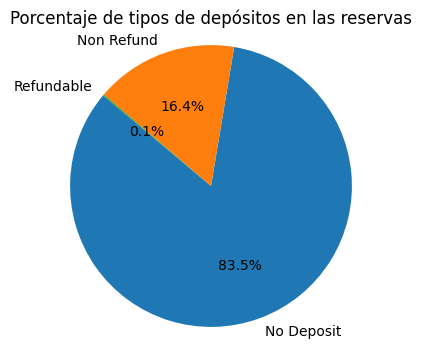

In [278]:
deposit_type_counts = hotels_df['deposit_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(deposit_type_counts, labels=deposit_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de tipos de depósitos en las reservas')
plt.axis('equal')
plt.show()

La gran mayoría de los clientes no realizaron un depósito, un 16,4% realizó el depósito completo o más y el restante porcentaje realizó una parte del depósito.

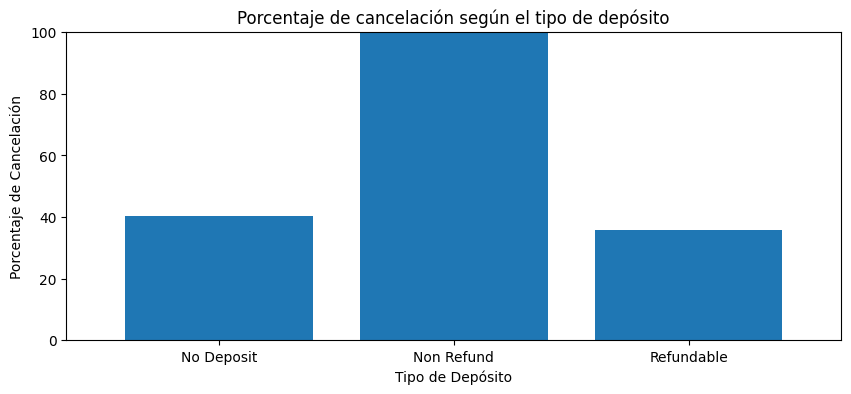

In [279]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('deposit_type')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación según el tipo de depósito')
plt.xlabel('Tipo de Depósito')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

Como se puede observar, Non Refund (No reembolsable), implica que se canceló la reserva y que no se devolvió el dinero. Reembolsable, implica que se canceló, pero que recibieron el dinero de vuelta y No Deposit que nunca se depositó el dinero.  
Entonces, este parámetro muestra que para todas las cancelaciones no se reembolsó el dinero, y los demás parámetros se mantuvieron aproximadamente sin variaciones realmente grandes.

Este parámetro no parece particularmente **relevante** para predecir si una reserva será cancelada a futuro o no, ni tampoco guarda una relación estrecha con el **target**

#### agent

El parámetro agent es un identificador que relaciona la agencia de viajes con la reserva, no tiene relación en sí con la cancelación de una reserva en principio, aunque podría suceder que con alguna agencia en particular la cantidad de reservas canceladas sea mayor, por lo que se propone investigar un poco más. Es una **Variable Independiente Cualitativa Texto Nominal**, ya que es una etiqueta no relacionada.

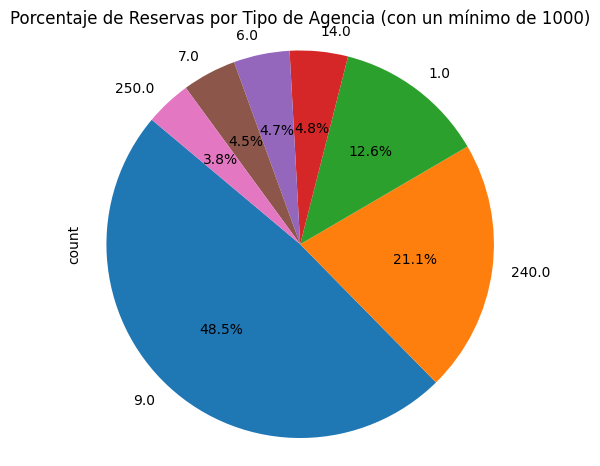

In [280]:
hotels_df_copy = hotels_df.copy()
min_reservations = 1000
reservations_counts = hotels_df_copy['agent'].value_counts()
valid_reservations_counts = reservations_counts[reservations_counts >= min_reservations]

plt.figure(figsize=(5.5, 5.5))
valid_reservations_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas por Tipo de Agencia (con un mínimo de {})'.format(min_reservations))
plt.axis('equal')
plt.show()

En el gráfico pastel se muestran las agencias que hicieron al menos 1000 reservas. Como puede observarse hay mucha diferencia entre agencias.

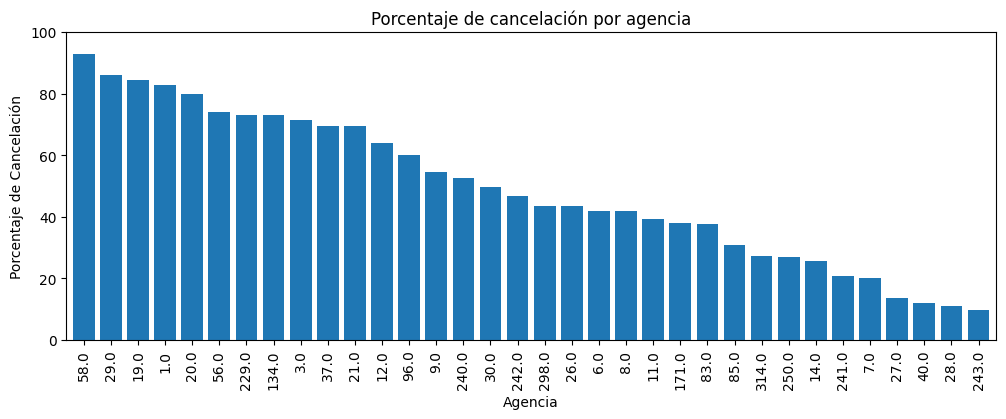

In [281]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('agent')['is_canceled'].mean() * 100

# Propongo un mínimo de reservas para comparar, en este caso 200
min_reservations = 200
agencies_with_min_reservations = hotels_df_copy['agent'].value_counts() >= min_reservations
cancellation_percentages = cancellation_percentages[agencies_with_min_reservations]
cancellation_percentages = cancellation_percentages.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación por agencia')
plt.xlabel('Agencia')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.show()

In [282]:
nan_count = hotels_df['agent'].isna().sum()
non_nan_count = hotels_df_copy['agent'].count()
total_count = nan_count + non_nan_count

print("Cantidad de valores vacíos en la columna 'agent': ", nan_count)
print("Porcentaje de valores vacíos con respecto al total en la columna 'agent': ", (nan_count / total_count) * 100)

Cantidad de valores vacíos en la columna 'agent':  7890
Porcentaje de valores vacíos con respecto al total en la columna 'agent':  12.74368872450051


Como se puede observar, el ID de la agencia relacionado con el porcentaje de cancelación es muy variable dependiendo la agencia. Esto podría significar que el servicio de algunas agencias es muy malo y por eso el porcentaje de cancelación es mucho mayor, aunque es solo una suposición. Lo que si es seguro que, para un mínimo de 200 reservas, un porcentaje de cancelación mayor al 60% es muy alto.  
Tal vez esto se debe a algún problema con la empresa en el momento que ahora puede haber cambiado su situación, pero es un parámetro a continuar analizando. Por lo pronto, como una exploración inicial resulta **relevante** y está relacionado con el **target**.
Vale aclarar que hay muchos valores vacíos (NaN), pero en comparación con el total puede despreciarse como exploración inicial.

#### company

De manera similar al anterior parámetro, es una **Variable Independiente Cualitativa Texto Nominal**. Se presentan un gráfico pastel para mostrar el porcentaje de ventas de las mayores companías, para un mínimo de 100 reservas:

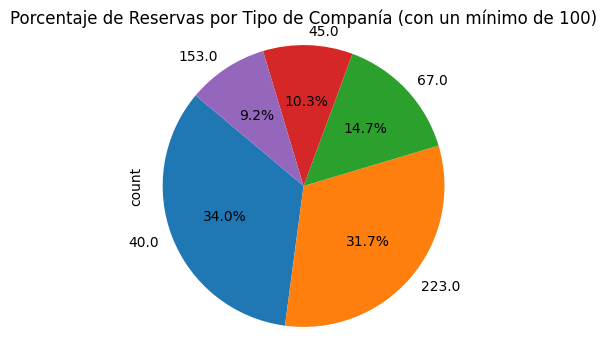

In [283]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy = hotels_df_copy.dropna(subset=['company'])
min_reservations = 100 
reservations_counts = hotels_df_copy['company'].value_counts()
valid_reservations_counts = reservations_counts[reservations_counts >= min_reservations]

plt.figure(figsize=(4, 4))
valid_reservations_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas por Tipo de Companía (con un mínimo de {})'.format(min_reservations))
plt.axis('equal')
plt.show()

De forma análoga a la agencia, ahora se presentan los porcentajes de cancelación:

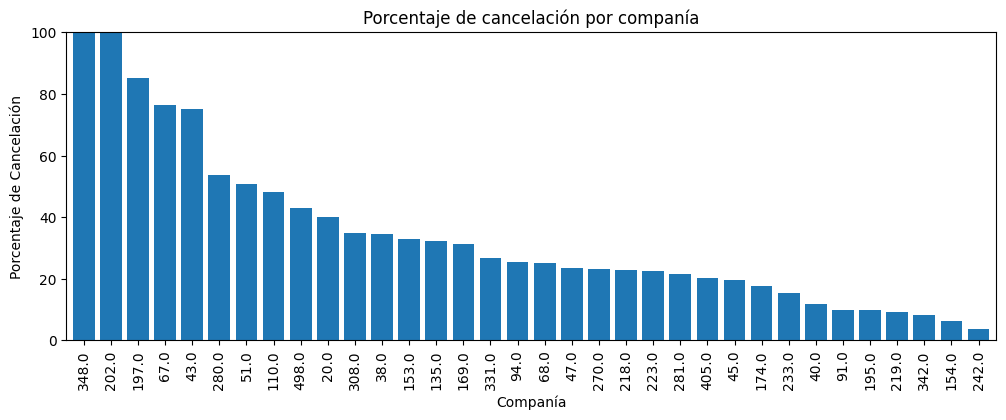

In [284]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('company')['is_canceled'].mean() * 100

min_reservations = 20
agencies_with_min_reservations = hotels_df_copy['company'].value_counts() >= min_reservations
cancellation_percentages = cancellation_percentages[agencies_with_min_reservations]
cancellation_percentages = cancellation_percentages.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación por companía')
plt.xlabel('Companía')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.show()

In [285]:
nan_count = hotels_df['company'].isna().sum()
non_nan_count = hotels_df_copy['company'].count()
total_count = nan_count + non_nan_count

print("Cantidad de valores vacíos en la columna 'company': ", nan_count)
print("Porcentaje de valores vacíos con respecto al total en la columna 'company': ", (nan_count / total_count) * 100)

Cantidad de valores vacíos en la columna 'company':  58761
Porcentaje de valores vacíos con respecto al total en la columna 'company':  94.90898518889409


Como puede observarse varía mucho dependiendo la companía, aunque en los datos hay muchos valores vacíos o NaN; por lo que se sugiere no tener en cuenta esta columna. De esta manera, lo mejor es considerarla **irrelevante** y no apta para relacionarla con el **target**, ya que su porcentaje de valores vacíos es mayor al 90%.

#### days_in_waiting_list

Este parámetro indica la cantidad de días que estuvo en la lista de espera la reserva. Es probable que a mayor cantidad de días de espera, la reserva haya sido cancelada. Es una **Variable Independiente Cuantitativa Discreta**, es una discretización del tiempo. Se propone calcular las medidas de resumen y volcar los datos en gráficos para comprobar la relación con target.

In [286]:
parameter_column = hotels_df['days_in_waiting_list'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2.6389772745626927
Mediana:  0.0
Varianza:  346.66500444237914
Desviación Estandar:  18.618942087089135
Moda:  0
Covarianza (con respecto a target):  0.473178126175147
Correlación de Pearson (con respecto a target):  0.050826791408983704


Como puede observarse la Media de espera es de aproximadamente 3 días, pero con un desvío estandar bastante alto. Así mismo, la Moda es 0, por lo que muchas reservas se pudieron efectuar en el momento. En cuanto a la Correlación de Pearson, no parece que haya una correlación muy fuerte con el target en principio.

A continuación, se presenta un gráfico con los porcentajes de reserva en los que fue necesario esperar y los que no.

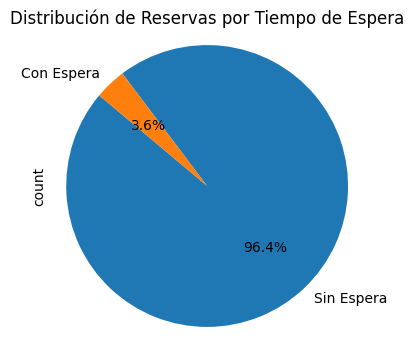

In [287]:
hotels_df_copy = hotels_df.copy()
waiting_list_counts = hotels_df_copy['days_in_waiting_list'].apply(lambda x: 'Sin Espera' if x == 0 else 'Con Espera')
waiting_list_counts = waiting_list_counts.value_counts()

plt.figure(figsize=(4, 4))
waiting_list_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Reservas por Tiempo de Espera')
plt.axis('equal')
plt.show()

Como puede observarse, la mayoría de las reservas se hicieron sin espera. Ahora se propone, volcar los porcentajes de cancelación dependiendo si hubo espera o no la hubo.

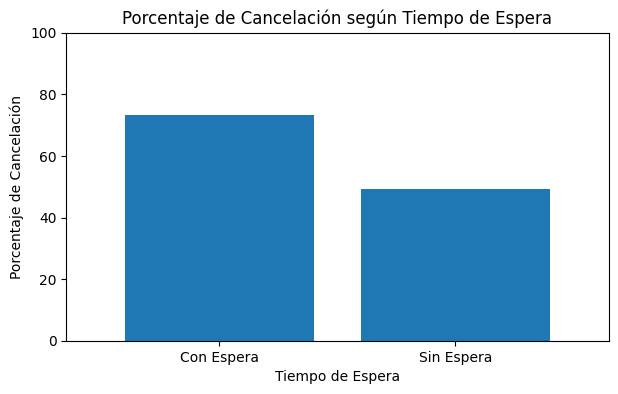

In [288]:
hotels_df_copy['days_in_waiting_list'].fillna(0, inplace=True)
hotels_df_copy['waiting_list_category'] = hotels_df_copy['days_in_waiting_list'].apply(lambda x: 'Sin Espera' if x == 0 else 'Con Espera')
cancellation_percentages = hotels_df_copy.groupby('waiting_list_category')['is_canceled'].mean() * 100

plt.figure(figsize=(7, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación según Tiempo de Espera')
plt.xlabel('Tiempo de Espera')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

Es claro que a mayor tiempo de espera de reserva, el porcentaje de cancelación aumenta. A continuación se presenta otro gráfico mostrando con los diversos días de espera por intervalo de 30 días:

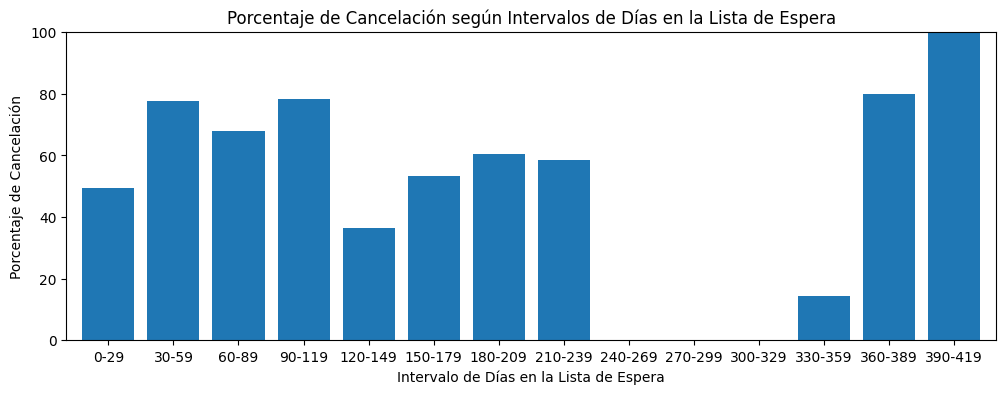

In [289]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['days_in_waiting_list'].fillna(0, inplace=True)
max_days_waiting = hotels_df_copy['days_in_waiting_list'].max()
interval_size = 30
num_intervals = int(max_days_waiting / interval_size) + 1
intervalos = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]
etiquetas = [f'{start}-{end-1}' for start, end in intervalos]
hotels_df_copy['waiting_list_interval'] = pd.cut(hotels_df_copy['days_in_waiting_list'], bins=[start-1 for start, end in intervalos] + [float('inf')], labels=etiquetas)
cancellation_percentages = hotels_df_copy.groupby('waiting_list_interval', observed=False)['is_canceled'].mean() * 100

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación según Intervalos de Días en la Lista de Espera')
plt.xlabel('Intervalo de Días en la Lista de Espera')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

Si bien hay variación, es claro que a mayor espera, la mayoría aumenta el porcentaje de cancelación. Por lo que es **relevante** para el entrenamiento del modelo y está fuertemente relacionada con el **target**.

#### customer_type

Este parámetro es una **Variable Independiente Cualitativa Texto Nominal** que indica el tipo de booking. Se propone, mostrar los valores más frecuentes en un gráfico de torta y luego analizar su relación con el target.

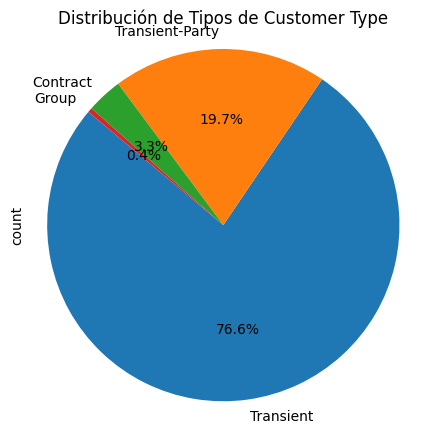

In [290]:
customer_type_counts = hotels_df['customer_type'].value_counts()

plt.figure(figsize=(5, 5))
customer_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Tipos de Customer Type')
plt.axis('equal')
plt.show()

Como se puede observar, la gran mayoría son Transient y en un porcentaje mucho menor Group. Se propone ahora analizar su relación con la variable target, analizando la probabilidad de cancelación dependiendo el grupo.

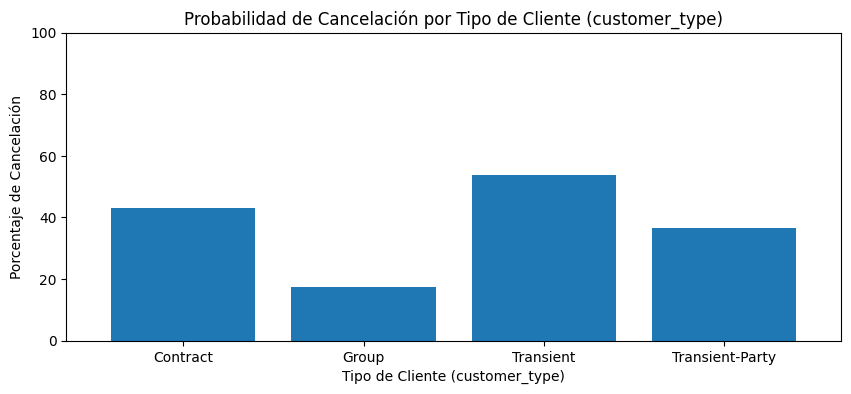

In [291]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('customer_type')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Probabilidad de Cancelación por Tipo de Cliente (customer_type)')
plt.xlabel('Tipo de Cliente (customer_type)')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

Es claro que hay una diferencia apreciable entre los distintos tipos, incluso entre Transient y Transient-Party que son los que más porcentaje poseen con respecto al total. Por lo que es un parámetro **relevante** para el entrenamiento del modelo y posee una relación fuerte con la variable **target**.

adr

Este parámetro es la Tarifa Promedio Diaria, que es una **Variable Independiente Cuantitativa Continua**. Se propone analizar el aumento de la tarifa con respecto a las cancelaciones de reservas.

En primer lugar se mostrarán la cantidad de reservas por precios de tarifas en un Density Plot

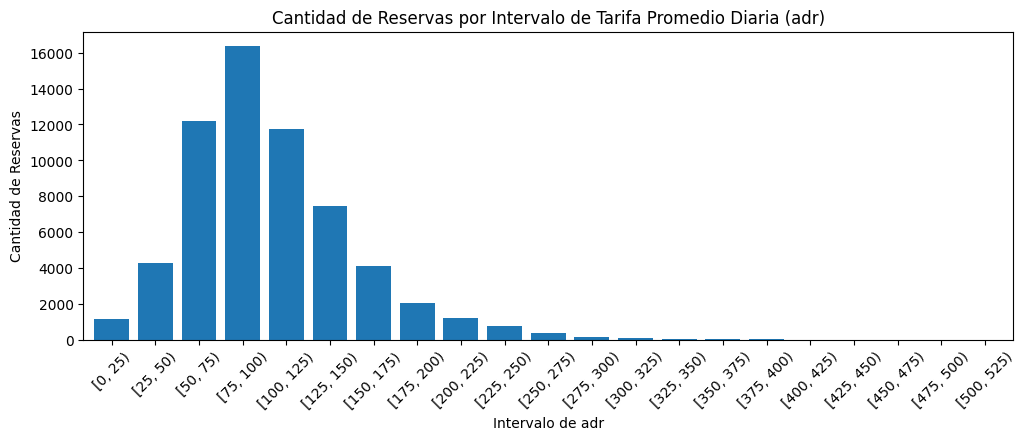

In [292]:
hotels_df_copy = hotels_df.copy()
adr_intervals = range(0, int(hotels_df_copy['adr'].max()) + 26, 25)
adr_counts = pd.cut(hotels_df_copy['adr'], bins=adr_intervals, right=False).value_counts().sort_index()

plt.figure(figsize=(12, 4))
adr_counts.plot(kind='bar', width=0.8)
plt.title('Cantidad de Reservas por Intervalo de Tarifa Promedio Diaria (adr)')
plt.xlabel('Intervalo de adr')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=45)
plt.show()

Como se puede observar, la mayor cantidad de reservas se encuentran entre 75 y 100 de tarifa diaria de gasto. Se puede observar que toma la forma de una Campana de Gauss discretizada. Se propone ahora analizar el porcentaje de cancelación dependiendo el adr.

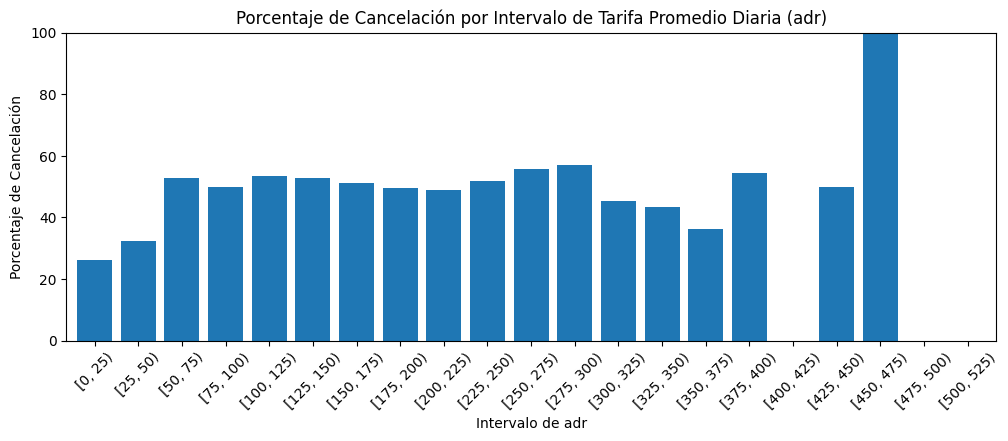

In [293]:
hotels_df_copy = hotels_df.copy()
adr_intervals = range(0, int(hotels_df_copy['adr'].max()) + 26, 25)
hotels_df_copy['adr_interval'] = pd.cut(hotels_df_copy['adr'], bins=adr_intervals, right=False)
cancellation_percentages = hotels_df_copy.groupby('adr_interval', observed=False)['is_canceled'].mean() * 100

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación por Intervalo de Tarifa Promedio Diaria (adr)')
plt.xlabel('Intervalo de adr')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

En general parece mantenerse el porcentaje de cancelación, salvo para valores menores a 50 adr ya que es menor, pero al mismo tiempo hay menor cantidad de reservas para estos valores. Lo mismo para valores muy grandes que aumenta mucho, aunque podría ser un outlier también. De todas maneras, no parece que el parámetro tenga una relación tan fuerte con el **target**, por lo que se lo considerará **irrelevante**.

#### required_car_parking_spaces

Este parámetro indica el número de autos requeridos para estacionamiento, es una **Variable Independiente Cuantitativa Discreta**. Se propone mostrar el porcentaje de clientes que requirieron de al menos un espacio para estacionamiento y luego su relación con el target.

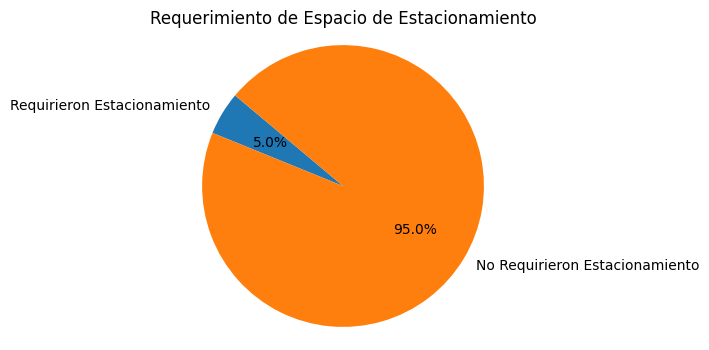

In [294]:
hotels_df_copy = hotels_df.copy()
parking_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] >= 1]
parking_not_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] == 0]

plt.figure(figsize=(4, 4))
plt.pie([len(parking_required), len(parking_not_required)], labels=['Requirieron Estacionamiento', 'No Requirieron Estacionamiento'], autopct='%1.1f%%', startangle=140)
plt.title('Requerimiento de Espacio de Estacionamiento')
plt.axis('equal')
plt.show()

Como se puede observar, la gran mayoría de clientes no requirieron de al menos un estacionamiento, pero un 5% sí lo hizo. Por lo que, ahora se analizará en cuanto afecta el porcentaje de cancelación:

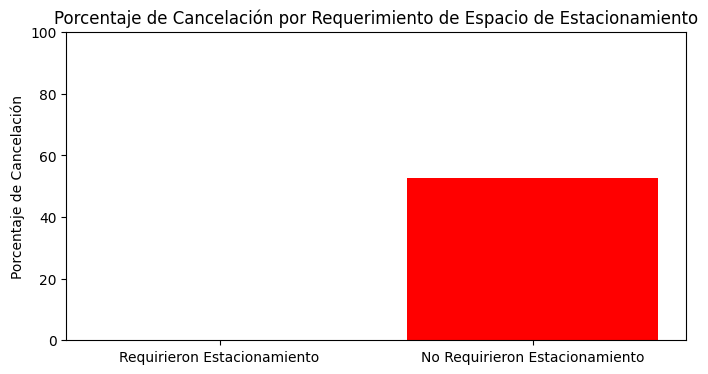

In [295]:
hotels_df_copy = hotels_df.copy()
parking_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] >= 1]
cancellation_percentage_required = parking_required['is_canceled'].mean() * 100
parking_not_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] == 0]
cancellation_percentage_not_required = parking_not_required['is_canceled'].mean() * 100

plt.figure(figsize=(8, 4))
plt.bar(['Requirieron Estacionamiento', 'No Requirieron Estacionamiento'], [cancellation_percentage_required, cancellation_percentage_not_required], color=['blue', 'red'])
plt.title('Porcentaje de Cancelación por Requerimiento de Espacio de Estacionamiento')
plt.ylabel('Porcentaje de Cancelación')
plt.ylim(0, 100) 
plt.show()

El gráfico arroja que todos los clientes que requirieron un estacionamiento no cancelaron su reserva, lo cual es un poco extraño.

In [296]:
hotels_df_copy = hotels_df.copy()
cancelled_bookings = hotels_df_copy[hotels_df_copy['is_canceled'] == 1]
with_parking_cancelled = cancelled_bookings[cancelled_bookings['required_car_parking_spaces'] >= 1]
without_parking_cancelled = cancelled_bookings[cancelled_bookings['required_car_parking_spaces'] == 0]

print("Cantidad de clientes que cancelaron con espacio de estacionamiento reservado:", len(with_parking_cancelled))
print("Cantidad de clientes que cancelaron sin espacio de estacionamiento reservado:", len(without_parking_cancelled))

Cantidad de clientes que cancelaron con espacio de estacionamiento reservado: 0
Cantidad de clientes que cancelaron sin espacio de estacionamiento reservado: 30941


Es muy extraño que 30941 clientes no haya cancelado su reserva ni siquiera 1, por lo que o bien solicitaron el estacionamiento una vez que llegaron al lugar, o bien los datos no son correctos. De esta manera, se considera el parámetro **irrelevante** para el entrenamiento del modelo y no relacionado con el **target**.

#### total_of_special_requests

De forma similar al anterior, este parámetro indica el número de pedidos especiales hechos por el cliente. Es una **Variable Independiente Cuantitativa Discreta**. Se propone mostrar, en un gráfico de torta el porcentaje de pedidos especiales hechos por clientes y el porcentaje que no pidió nada.

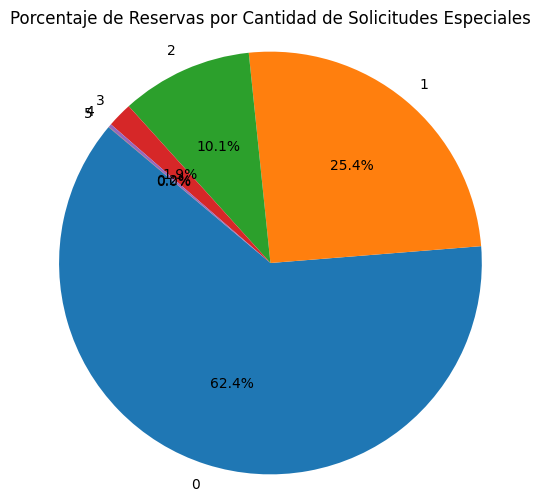

In [297]:
hotels_df_copy = hotels_df.copy()
special_requests_counts = hotels_df_copy.groupby('total_of_special_requests').size()
total_reservations = special_requests_counts.sum()
percentage_by_requests = (special_requests_counts / total_reservations) * 100

plt.figure(figsize=(6, 6))
percentage_by_requests.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas por Cantidad de Solicitudes Especiales')
plt.axis('equal')
plt.show()

Parece que un 62% aproximadamente no realizó pedidos especiales, pero el restante 38% hizo al menos 1 pedido. A continuación, se propone analizar la relación con respecto al target

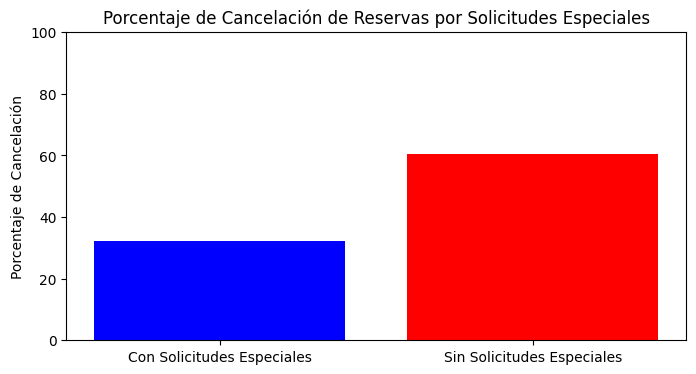

In [298]:
hotels_df_copy = hotels_df.copy()
with_special_requests = hotels_df_copy[hotels_df_copy['total_of_special_requests'] > 0]
without_special_requests = hotels_df_copy[hotels_df_copy['total_of_special_requests'] == 0]
cancellation_percentage_with = (with_special_requests['is_canceled'].mean()) * 100
cancellation_percentage_without = (without_special_requests['is_canceled'].mean()) * 100

plt.figure(figsize=(8, 4))
plt.bar(['Con Solicitudes Especiales', 'Sin Solicitudes Especiales'], [cancellation_percentage_with, cancellation_percentage_without], color=['blue', 'red'])
plt.title('Porcentaje de Cancelación de Reservas por Solicitudes Especiales')
plt.ylabel('Porcentaje de Cancelación')
plt.ylim(0, 100)
plt.show()

Parece que es mucho mayor el porcentaje de reservas canceladas que no tenían solicitudes especiales, resta analizar los casos más específicos:

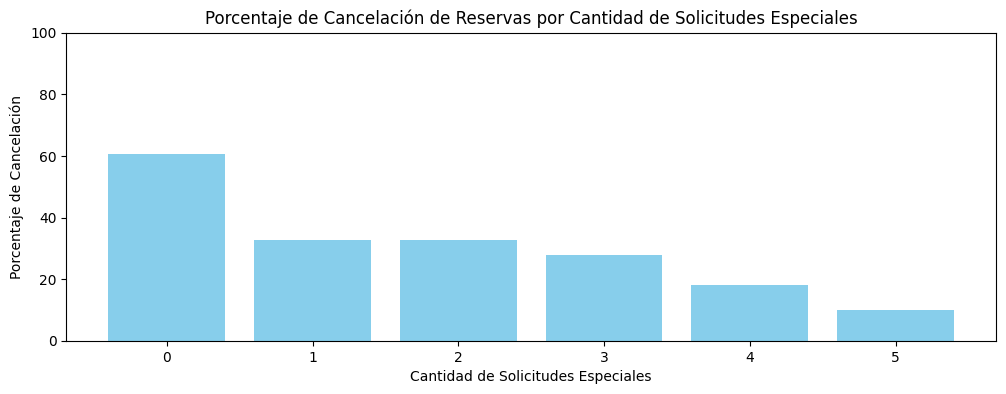

In [299]:
hotels_df_copy = hotels_df.copy()
unique_special_requests = hotels_df_copy['total_of_special_requests'].unique()
cancellation_percentages = []

for request_count in unique_special_requests:
    subset = hotels_df_copy[hotels_df_copy['total_of_special_requests'] == request_count]
    cancellation_percentage = (subset['is_canceled'].mean()) * 100
    cancellation_percentages.append(cancellation_percentage)

plt.figure(figsize=(12, 4))
plt.bar(unique_special_requests, cancellation_percentages, color='skyblue')
plt.title('Porcentaje de Cancelación de Reservas por Cantidad de Solicitudes Especiales')
plt.xlabel('Cantidad de Solicitudes Especiales')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(unique_special_requests)
plt.ylim(0, 100)
plt.show()

Como puede observarse el porcentaje de cancelación disminuye para mayor cantidad de solicitudes especiales, entonces es un parámetro **relevante** y que tiene una fuerte relación con el **target**.

#### id

Este parámetro simplemente indica el id de la reserva, no tiene sentido analizarlo. Es una **Variable Independiente Cualitativa Texto Nominal** ya que es una etiqueta sin relación alguna más que para identificar la reserva.

Vale aclarar que es **irrelevante** para el entrenamiento del modelo y no tiene una relación fuerte con el **target**.

#### is_canceled

Este parámetro es un binario que simplemente muestra si una reserva fue cancelada o no. Es una **Variable Independiente Cualitativa Numérica Nominal**.

Desde ya que es **irrelevante** para el entrenamiento del modelo, porque es lo que se quiere predecir, y es el **target** en sí mismo.

In [300]:
total_reservations = len(hotels_df)
cancelled_reservations = len(hotels_df[hotels_df['is_canceled'] == 1])

print("Cantidad Total de Reservas:", total_reservations)
print("Cantidad de Reservas Canceladas:", cancelled_reservations)

Cantidad Total de Reservas: 61913
Cantidad de Reservas Canceladas: 30941


En el siguiente gráfico de torta, se muestra el porcentaje de reservas canceladas con respecto al total

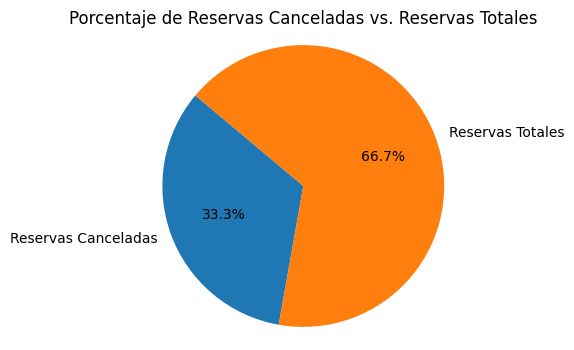

In [301]:
hotels_df_copy = hotels_df.copy()
total_reservations = len(hotels_df_copy)
cancelled_reservations = len(hotels_df_copy[hotels_df_copy['is_canceled'] == 1])
percentage_total = (total_reservations / total_reservations) * 100
percentage_cancelled = (cancelled_reservations / total_reservations) * 100

plt.figure(figsize=(4, 4))
plt.pie([percentage_cancelled, percentage_total], labels=['Reservas Canceladas', 'Reservas Totales'], autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas Canceladas vs. Reservas Totales')
plt.axis('equal')
plt.show()

Se puede observar que 1 de cada 3 reservas se cancela. Este es un dato no menor, es una cifra bastante alta, por lo que analizando los datos y tomando medidas las companías y agencias de viajes buscarán disminuir el porcentaje de reservas canceladas al mínimo posible.

#### RESUMEN

A modo de resumen se muestra una lista de los parámetros **relevantes** y los **irrelevantes** en esta primer exploración inicial:  
  
**Relevantes:**  
* hotel  
* lead_time  
* arrival_date_month
* arrival_date_week_number  
* adults  
* meal  
* country  
* market_segment  
* distribution_channel  
* is_repeated_guest  
* previous_cancellations  
* previous_bookings_not_canceled  
* assigned_room_type  
* booking_changes  
* agent  
* customer_type  
* days_in_waiting_list  
* total_of_special_requests  
  
  
**Irrelevantes:**  
* arrival_date_year  
* arrival_date_day_of_month  
* stays_in_weeknd_nights  
* stays_in_week_days  
* children  
* babies  
* reserved_room_type  
* deposit_type  
* company  
* adr  
* required_car_parking_spaces  
* id

## Visualización de los Datos

## Datos Faltantes

A continuación se numeran la cantidad de datos faltantes para cada variable que los tenga:

In [302]:
datosFaltantes_df = pd.DataFrame(columns = ["Variable","Valores Faltantes", "Porcentaje"])

for i in hotels_df:
    nValoresFaltantes = hotels_df[i].isna().sum()
    if nValoresFaltantes > 0:
        datosFaltantes_df.loc[len(datosFaltantes_df.index)] = (i, nValoresFaltantes, (nValoresFaltantes*100/len(hotels_df.index)))

datosFaltantes_df.style.hide(axis="index").format(precision = 3, decimal = ',', thousands = '.')

Variable,Valores Faltantes,Porcentaje
children,4,"0,006"
country,221,"0,357"
agent,7.890,"12,744"
company,58.761,"94,909"


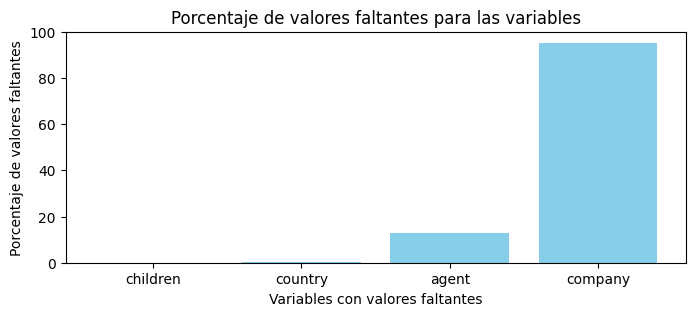

In [303]:
plt.figure(figsize=(8, 3))
plt.bar(datosFaltantes_df["Variable"], datosFaltantes_df["Porcentaje"], color='skyblue')
plt.title('Porcentaje de valores faltantes para las variables')
plt.xlabel('Variables con valores faltantes')
plt.ylabel('Porcentaje de valores faltantes')
plt.ylim(0, 100)
plt.show()

Dado a que children y company no son variables relevantes no se considerarán al momento de hacer el modelo y por lo tanto no se analizará qué hacer con sus valores faltantes.

## Valores Atípicos

# Clasificación - Entrenamiento y Predicción